# Introduction 

L'objectif du présent mandant est d'établir un modèle capable de détection les fraudes en assurance automobile. Les réclamations frauduleuses en assurance automobile représentent un enjeu important pour les assurances car en étant capable de les détecter elles pourraient éviter de débourser de gros montants pour du faux et avoir plus de ressources pour l'indemnisations des vraies réclamations.

In [282]:
# Valeurs manquantes 
import missingno as msno 

# Visualisation 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Traitement des données
import pandas as pd
import numpy as np

# Encodage 
from sklearn.preprocessing import LabelEncoder

# Gestion des Outliers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# VarianceThreshold
from sklearn.feature_selection import VarianceThreshold

# RFECV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Réduction de dimensions
import prince 

# SMOTE 
from imblearn.over_sampling import SMOTE

# Machine learning - Préparation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer

# Algo de machine learning 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import lightgbm as lgb
import xgboost as xgb 
from catboost import CatBoostClassifier 


# Optuna - Optimisation
import optuna
from optuna.samplers import TPESampler

# Inportance des variables
from sklearn.inspection import permutation_importance

In [149]:
df = pd.read_csv("data/fraud_oracle.csv")
df.shape

(15420, 33)

In [3]:
pd.set_option("display.max_columns", None)

## Définition des variables 
- **Month** : Le mois dans lequel la réclamation d'assurance a été faite
- **WeekOfMonth** : La semaine du mois dans laquelle la réclamation a été faite
- **DayOfWeek** : Le jour de la semaine pour lequel la réclamation a été faite
- **Make** : La marque du véhicule assuré
- **AccidentArea** : L'aire dans laquelle l'accident a eu lieu
- **DayOfWeekClaimed** : Le jour de la semaine pour lequel la réclamation a été traitée
- **MonthClaimed** : Le mois pour lequel la réclamation a été traitée
- **WeekOfMonthClaimed** : La semaine du mois pour laquelle la réclamation a été traitée
- **Sex** : Le sexe de l'assuré
- **MaritalStatus** : Le statut matrimonial de l'assuré
- **Age** : l'age de l'assuré
- **Fault** : indique si l'assuré est le responsable de l'accident
- **PolicyType** : Le type d'asssurance souscrit
- **VehicleCategory** : La catégorie du véhicule (ex: SUV, sport...)
- **VehiclePrice** : Le prix du véhicule
- **FraudFound_P** : indique s'il y a eu une fraude pour la réclamation en question
- **PolicyNumber** : Identifiant unique pour chaque police
- **RepNumber** : Identifiant unique pour les réclamations
- **Deductible** : Le montant de la franchise à la charge de l'assuré avant que l'assureur ne paie pour une réclamation
- **DriverRating** : Niveau de conduite de l'assuré
- **Days_Policy_Claim** : Le nombre de jours de couverture de la police avant la réclamation
- **PastNumberOfClaims** : Le nombre de réclamations passées
- **AgeOfVehicle** : L'age du véhicule impliqué dans l'accident
- **AgeOfPolicyHolder** : L'age du titulaire de police
- **PoliceReportedFiled** : Indique s'il y a un rapport de police ou non
- **WitnessPresent** : Indique s'il y a des témoins ou non
- **AgentType** : Le type d'agent d'assurance qui a pris en charge la réclamation
- **NumberOfSuppliments** : Le nombre de documents supplémentaires ou réclamations reliée à la même réclamation
- **AdressChange_Claim** : Indique si l'adresse du titulaire de police a changé au moment de la réclamation
- **NumberOfCars** : Le nombre de véhicules assurés par la police
- **Year** : L'année dans laquelle la réclamation a été traitée
- **BasePolicy** : Les types de couvertures (ex: Responsabilité, colision, ....)

In [4]:
df.head()

Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  Age          Fault  \
0          Jan                   1  Female        Single   21  Policy Holder   
1          Jan                   4    Male        Single   34  Policy Holder   
2          Nov                   2    Male       Married   47  Policy Holder   
3          Jul                   1    Male       Married   65    Third Party   
4          Feb                   2  Female        Single   27    Third Party   

          PolicyType VehicleCategory     VehiclePrice  FraudFound_P  \
0  Sport - Liability           Sport  more than 69000             0   
1  Sport - Collision           Sport  more than 69000             0   
2  Sport - Collision           Sport  more than 69000             0   
3  Sedan - Liability           Sport   20000 to 29000             0   
4  Sport - Collision           Sport  more than 69000             0   

   PolicyNumber  RepNumber  Deductible  DriverRating Days_Policy_Accident  \
0             1         12         300             1         more than 30   
1             2         15         400             4         more than 30   
2             3          7         400             3         more than 30   
3             4          4         400             2         more than 30   
4             5          3         400             1         more than 30   

  Days_Policy_Claim PastNumberOfClaims AgeOfVehicle AgeOfPolicyHolder  \
0      more than 30               none      3 years          26 to 30   
1      more than 30               none      6 years          31 to 35   
2      more than 30                  1      7 years          41 to 50   
3      more than 30                  1  more than 7          51 to 65   
4      more than 30               none      5 years          31 to 35   

  PoliceReportFiled WitnessPresent AgentType NumberOfSuppliments  \
0                No             No  External                none   
1               Yes             No  External                none   
2                No             No  External                none   
3               Yes             No  External         more than 5   
4                No             No  External                none   

  AddressChange_Claim NumberOfCars  Year BasePolicy  
0              1 year       3 to 4  1994  Liability  
1           no change    1 vehicle  1994  Collision  
2           no change    1 vehicle  1994  Collision  
3           no change    1 vehicle  1994  Liability  
4           no change    1 vehicle  1994  Collision

## Valeurs manquantes 

<Axes: >

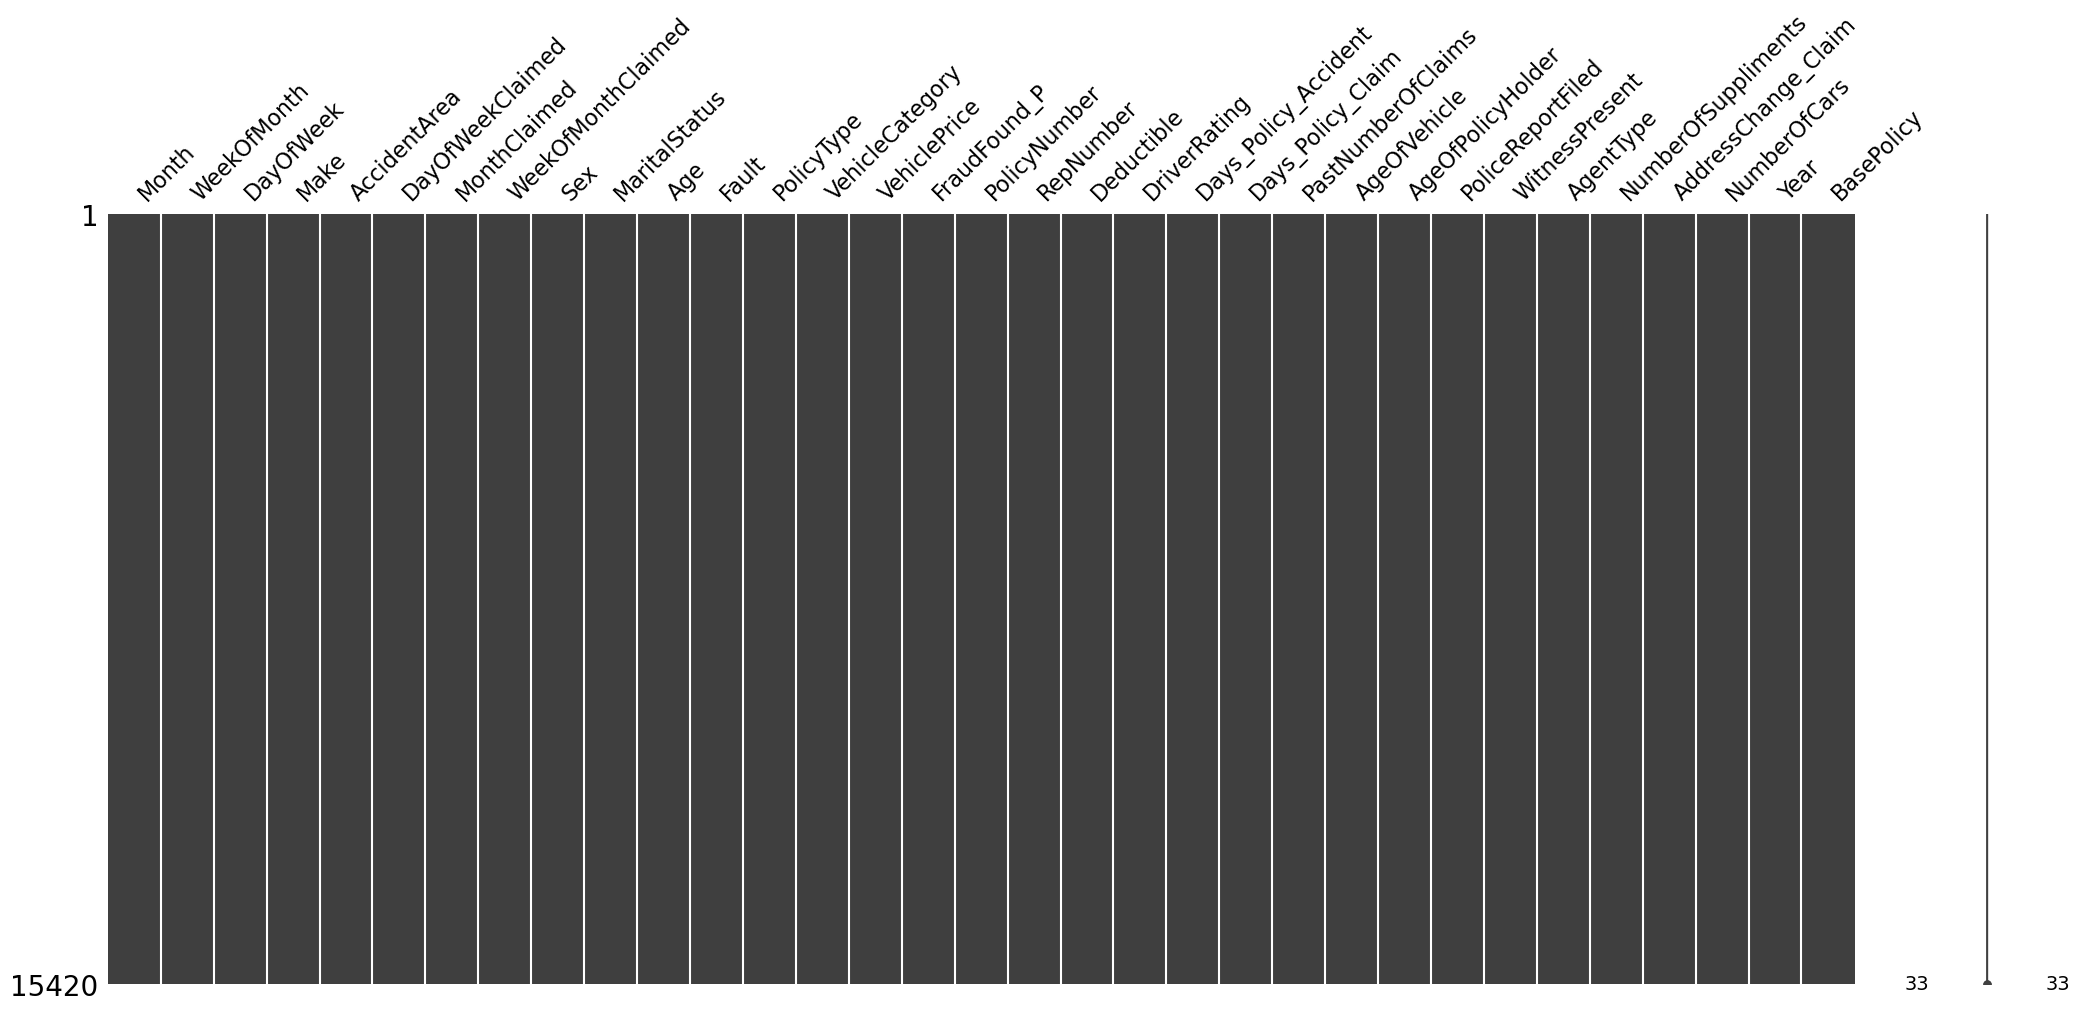

In [5]:
msno.matrix(df)

On ne note aucune valeur manquante dans les 33 variables.

## Résumés des données 

In [6]:
# Fonction pour obtenir les statistiques descriptives des variables des données
def summarize_df(Dataframe):

    summary = pd.DataFrame()

    # Type de données 
    summary["Data Type"] = Dataframe.dtypes

    # Nombre de valeur uniques
    summary["Unique values"] = Dataframe.nunique()

    # Les valeurs uniques 
    summary["Unique"] = Dataframe.apply(lambda x: x.unique().tolist())

    # Maximum
    summary["Max"] = Dataframe.apply(lambda x: x.max() if pd.api.types.is_numeric_dtype(x) else "-")

    # Minimum 
    summary["Min"] = Dataframe.apply(lambda x: x.min() if pd.api.types.is_numeric_dtype(x) else "-")

    # Moyenne, Médiane, Mode
    summary["Mean"] = Dataframe.apply(lambda x: round(x.mean(), 4) if pd.api.types.is_numeric_dtype(x) else "-")
    summary["Median"] = Dataframe.apply(lambda x: x.median() if pd.api.types.is_numeric_dtype(x) else "-")
    summary["Mode"] = Dataframe.apply(lambda x: x.mode().iloc[0] if pd.api.types.is_numeric_dtype(x) else "-")

    # Mesures de dispersion
    summary["Range"] = Dataframe.apply(lambda x: x.max() - x.min() if pd.api.types.is_numeric_dtype(x) else "-")
    summary["Variance"] = Dataframe.apply(lambda x: x.var() if pd.api.types.is_numeric_dtype(x) else "-")
    summary["Range"] = Dataframe.apply(lambda x: x.std() if pd.api.types.is_numeric_dtype(x) else "-")

    # Mesures de la forme de la distribution 
    summary["Skewness"] = Dataframe.apply(lambda x: round(x.skew(), 4) if pd.api.types.is_numeric_dtype(x) else "-")
    summary["Kurtosis"] = Dataframe.apply(lambda x: round(x.kurt(), 4) if pd.api.types.is_numeric_dtype(x) else "-")

    return summary

In [7]:
summary = summarize_df(df)
summary

Data Type  Unique values  \
Month                   object             12   
WeekOfMonth              int64              5   
DayOfWeek               object              7   
Make                    object             19   
AccidentArea            object              2   
DayOfWeekClaimed        object              8   
MonthClaimed            object             13   
WeekOfMonthClaimed       int64              5   
Sex                     object              2   
MaritalStatus           object              4   
Age                      int64             66   
Fault                   object              2   
PolicyType              object              9   
VehicleCategory         object              3   
VehiclePrice            object              6   
FraudFound_P             int64              2   
PolicyNumber             int64          15420   
RepNumber                int64             16   
Deductible               int64              4   
DriverRating             int64              4   
Days_Policy_Accident    object              5   
Days_Policy_Claim       object              4   
PastNumberOfClaims      object              4   
AgeOfVehicle            object              8   
AgeOfPolicyHolder       object              9   
PoliceReportFiled       object              2   
WitnessPresent          object              2   
AgentType               object              2   
NumberOfSuppliments     object              4   
AddressChange_Claim     object              5   
NumberOfCars            object              5   
Year                     int64              3   
BasePolicy              object              3   

                                                                 Unique  \
Month                 [Dec, Jan, Oct, Jun, Feb, Nov, Apr, Mar, Aug, ...   
WeekOfMonth                                             [5, 3, 2, 4, 1]   
DayOfWeek             [Wednesday, Friday, Saturday, Monday, Tuesday,...   
Make                  [Honda, Toyota, Ford, Mazda, Chevrolet, Pontia...   
AccidentArea                                             [Urban, Rural]   
DayOfWeekClaimed      [Tuesday, Monday, Thursday, Friday, Wednesday,...   
MonthClaimed          [Jan, Nov, Jul, Feb, Mar, Dec, Apr, Aug, May, ...   
WeekOfMonthClaimed                                      [1, 4, 2, 3, 5]   
Sex                                                      [Female, Male]   
MaritalStatus                        [Single, Married, Widow, Divorced]   
Age                   [21, 34, 47, 65, 27, 20, 36, 0, 30, 42, 71, 52...   
Fault                                      [Policy Holder, Third Party]   
PolicyType            [Sport - Liability, Sport - Collision, Sedan -...   
VehicleCategory                                 [Sport, Utility, Sedan]   
VehiclePrice          [more than 69000, 20000 to 29000, 30000 to 390...   
FraudFound_P                                                     [0, 1]   
PolicyNumber          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
RepNumber             [12, 15, 7, 4, 3, 14, 1, 13, 11, 16, 6, 2, 8, ...   
Deductible                                         [300, 400, 500, 700]   
DriverRating                                               [1, 4, 3, 2]   
Days_Policy_Accident    [more than 30, 15 to 30, none, 1 to 7, 8 to 15]   
Days_Policy_Claim               [more than 30, 15 to 30, 8 to 15, none]   
PastNumberOfClaims                       [none, 1, 2 to 4, more than 4]   
AgeOfVehicle          [3 years, 6 years, 7 years, more than 7, 5 yea...   
AgeOfPolicyHolder     [26 to 30, 31 to 35, 41 to 50, 51 to 65, 21 to...   
PoliceReportFiled                                             [No, Yes]   
WitnessPresent                                                [No, Yes]   
AgentType                                          [External, Internal]   
NumberOfSuppliments                 [none, more than 5, 3 to 5, 1 to 2]   
AddressChange_Claim   [1 year, no change, 4 to 8 years, 2 to 3 years...   
NumberOfCars          [3 to 4

- Les variables "MonthClaimed" et "DayOfWeekClaimed" qui devraient compter respectivement 12 et 7 modalités comptent 13 et 8 modalités due à la présence de 0 dans les observations
- Les variables comprenant 2 modalités peuvent être recoder en variables binaires : "Sex", "PoliceReportFiled", "WitnessPresent", "AccidentalArea", "Fault", "AgentType"
- On note un age minimum de 0 qu'il faudra traiter
- On peut supprimer "PolicyNumber" étant donné qu'elle ne fournit pas d'information sur un potentiel de fraude

## Analyse exploratoire des données 

In [150]:
df_1 = df.copy()

### Variable dépendante - Fraud_Found_P 

In [151]:
# Comptage du nombre de cas de fraude
fraud_counts = df_1["FraudFound_P"].value_counts().reset_index()
fraud_counts.columns = ["FraudFound_P", "Count"]
fraud_counts

FraudFound_P  Count
0             0  14497
1             1    923

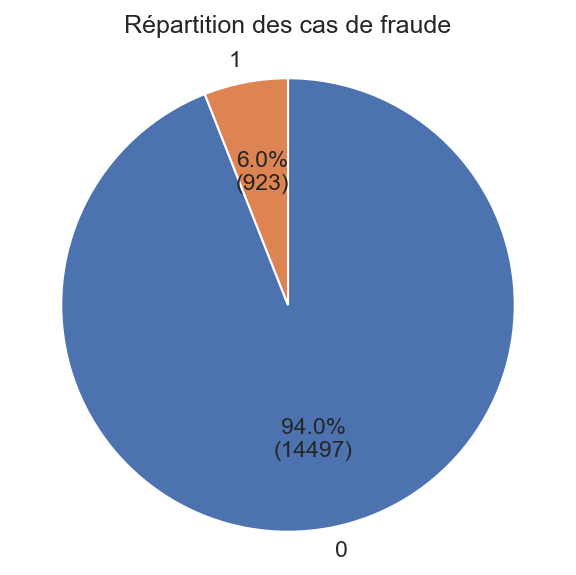

In [152]:
sns.set_theme(style="whitegrid")  

labels = fraud_counts["FraudFound_P"].astype(str)
sizes  = fraud_counts["Count"].to_numpy()

# Fonction d'affichage
def autopct_format(values):
    total = values.sum()
    def _fmt(pct):
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count})"
    return _fmt

# Graphique
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.pie(
    sizes,
    labels=labels,
    autopct=autopct_format(sizes),
    startangle=90,
    counterclock=False,
    wedgeprops=dict(linewidth=1, edgecolor="white"),
    textprops=dict(fontsize=11),
)
ax.axis("equal")  # cercle parfait
ax.set_title("Répartition des cas de fraude", pad=12)
plt.tight_layout()
plt.show()

On note qu'il y a très peu de cas de fraudes dans nos données. Cela pourrait induire un biais dans le modèle pour la classe majoritaire et donc une faible performance pour la classe minoritaire. Les métriques comme la précision pourrait ne pas être vraiment utiles car une haute précision pourrait être due à une bonne prédiction de la classe majoritaire. 




### Fraude et Sexe 

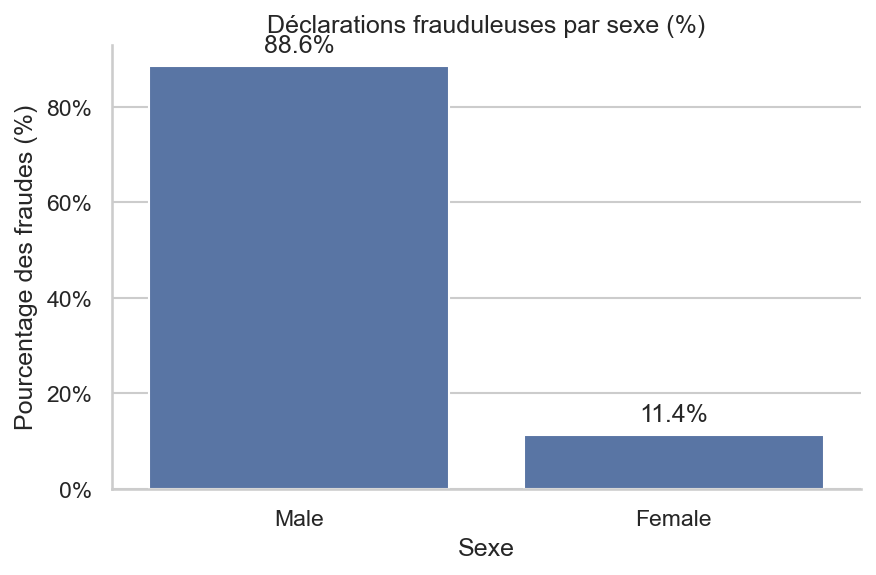

In [153]:
# Déclarations frauduleuses
df_fraud = df_1[df_1["FraudFound_P"] == 1]

# Distribution par sexe
fraud_counts_sex = df_fraud["Sex"].value_counts()
fraud_percentages_sex = (fraud_counts_sex / fraud_counts_sex.sum()) * 100
fraud_percentages_sex

# Transformation de la série en dataframe
plot_df = fraud_percentages_sex.rename_axis("Sex").reset_index(name="Percent")


# Barplot
plt.figure(figsize=(6, 4), dpi=150)
ax = sns.barplot(data=plot_df, x="Sex", y="Percent")

ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Sexe")
ax.set_ylabel("Pourcentage des fraudes (%)")
ax.set_title("Déclarations frauduleuses par sexe (%)")

# Annotations sur chaque barre
for p in ax.patches:
    val = p.get_height()
    ax.annotate(f"{val:.1f}%",
               (p.get_x() + p.get_width() / 2, val),
               ha="center", va="bottom",
               xytext=(0,4), textcoords="offset points")

sns.despine()
plt.tight_layout()
plt.show()

L'analyse de ce graphique montre que les hommes sont significativement plus impliqués dans les cas de réclamations frauduleuses que les femmes.

### Fraude et variables d'âge 

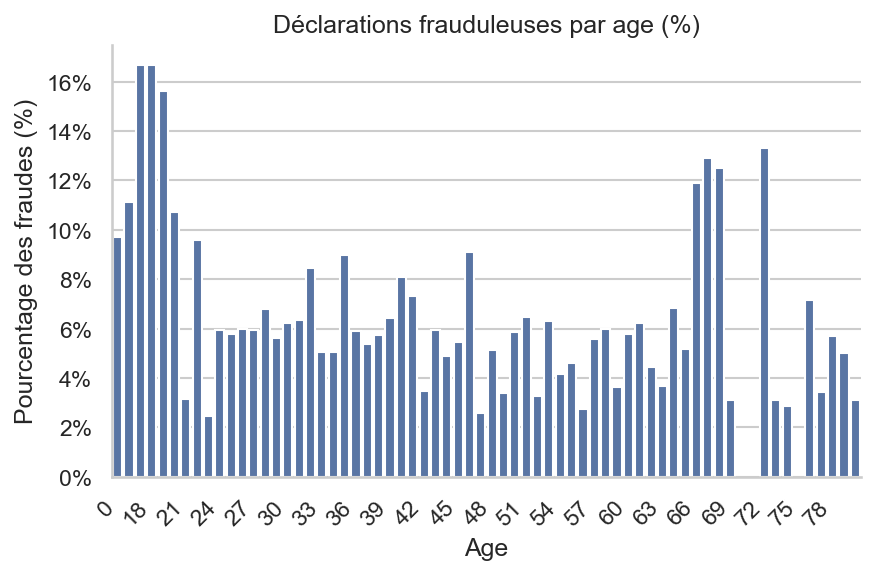

In [154]:
df_fraud = df_1[df_1["FraudFound_P"] == 1]
df_non_fraud = df_1[df_1["FraudFound_P"] == 0]

# Compter le nombre d'observations par âge
df_counts_age = df_1["Age"].value_counts().sort_index()
df_counts_fraud = df_fraud["Age"].value_counts().sort_index()

# Pourcentage de cas frauduleux par âge 
df_percentages_age_fraud = round((df_counts_fraud / df_counts_age) * 100, 2)


# dataframe
plot_df = df_percentages_age_fraud.rename_axis("Age").reset_index(name="Percent")
plot_df

# Barplot
plt.figure(figsize=(6, 4), dpi=150)
ax = sns.barplot(data=plot_df, x="Age", y="Percent")

step = max(1, len(plot_df) // 20)
ax.set_xticks(range(0, len(plot_df), step))
ax.set_xticklabels(plot_df["Age"].iloc[::step].astype(str), rotation=45, ha="right")

ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Age")
ax.set_ylabel("Pourcentage des fraudes (%)")
ax.set_title("Déclarations frauduleuses par age (%)")

sns.despine()
plt.tight_layout()
plt.show()

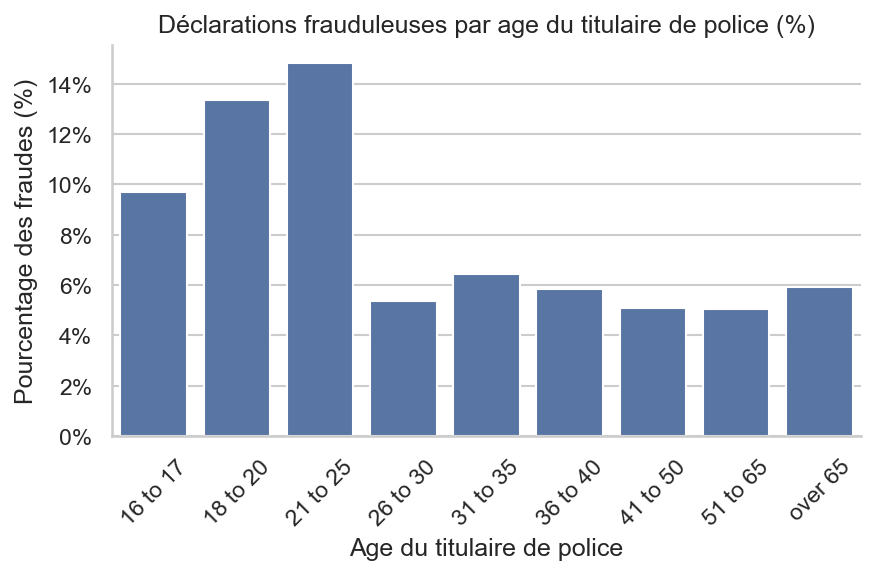

In [155]:
df_fraud = df_1[df_1["FraudFound_P"] == 1]
df_non_fraud = df_1[df_1["FraudFound_P"] == 0]

# Compter le nombre d'observations par âge
df_counts_age = df_1["AgeOfPolicyHolder"].value_counts().sort_index()
df_counts_fraud = df_fraud["AgeOfPolicyHolder"].value_counts().sort_index()

# Pourcentage de cas frauduleux par âge 
df_percentages_age_fraud = round((df_counts_fraud / df_counts_age) * 100, 2)


# dataframe
plot_df = df_percentages_age_fraud.rename_axis("Age du titulaire").reset_index(name="Percent")
plot_df

# Barplot
plt.figure(figsize=(6, 4), dpi=150)
ax = sns.barplot(data=plot_df, x="Age du titulaire", y="Percent")
ax.tick_params(axis="x", labelrotation=45)


ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Age du titulaire de police")
ax.set_ylabel("Pourcentage des fraudes (%)")
ax.set_title("Déclarations frauduleuses par age du titulaire de police (%)")

sns.despine()
plt.tight_layout()
plt.show()

Le premier graphique (la répartition par âge exact) montre la même tendance avec plus de bruit par année que le second graphique (par classe d'âge) qui est lisse et rend le signal plus clair. Dans ces données, la proportion de déclarations frauduleuses atteint un maximum chez les jeunes adultes (18 à 25 ans avec des proportions entre 13% et 15%) avec un niveau déjà elevé chez les adolescents, puis décroît nettement pour se stabiliser autour de 5-6% entre 26 et 65 ans. Au delà de 65 ans, on note une légère remontée.

La présence prépondérante de fraudes chez les jeunes pourraient être dû à leurs finances faibles étant donné qu'ils n'ont pas encore commencé à travailler ou à pleinement gagner leurs vies. Chez les vieux de plus de 65 ans, l'entrée à l'âge de la retraite est suivie d'une diminution des sources de revenues. En considérant ces hypothèses, il pourrait y avoir un lien entre la fraude et le revenu.

### Fraude et marque de véhicule

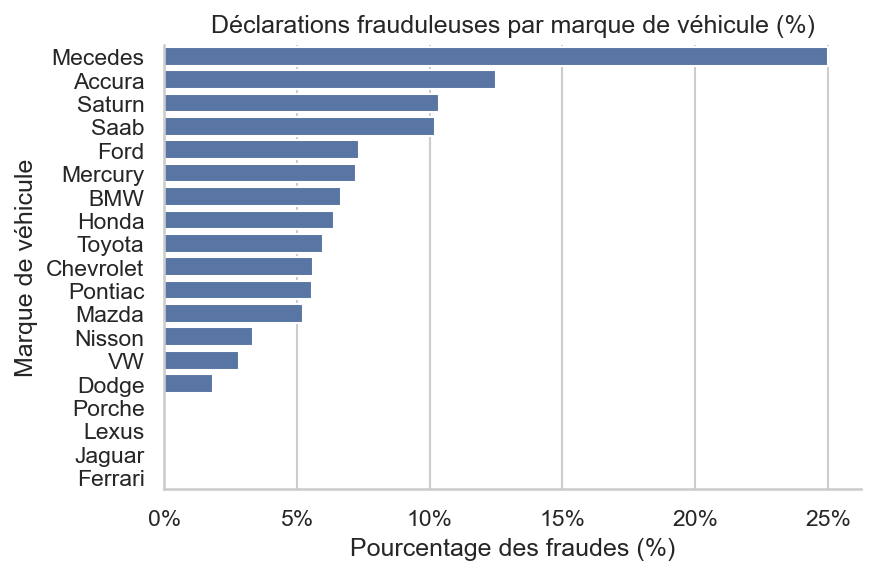

In [156]:
# Préparation des données pour visualisation
df_counts_make = df_1["Make"].value_counts().sort_index()
df_counts_make_fraud = df_fraud["Make"].value_counts().sort_index()
df_pertcentage_make_fraud = pd.DataFrame(round((df_counts_make_fraud / df_counts_make) * 100, 2)).fillna(0).reset_index()

df_pertcentage_make_fraud.columns = ["Make", "Fraud %"]
df_pertcentage_make_fraud = df_pertcentage_make_fraud.sort_values(by=["Fraud %", "Make"], ascending=False)

# Barplot
plt.figure(figsize=(6, 4), dpi=150)
ax = sns.barplot(data=df_pertcentage_make_fraud, x="Fraud %", y="Make")

ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Pourcentage des fraudes (%)")
ax.set_ylabel("Marque de véhicule")
ax.set_title("Déclarations frauduleuses par marque de véhicule (%)")

sns.despine()
plt.tight_layout()
plt.show()

Le graphique indique que la proportion de réclamations frauduleuses varie sensiblement selon la marque: **Mercedes** arrive nettement en tête, suivie de **Accura** puis d'un groupe intermétaire composé de **Saturn**, **Saab**, **Ford**, **Mercury** et **BMW**. Les marques les plus courantes comme **Honda**, **Toyota**, **Chevrolet**, **Pontiac**, **Mazda** et **Nisson** ont des proportions plus petite et décroissantes. Les marques plus de luxes comme **Porche**, **Lexus**, **Jaguar** et **Ferrari** affichent des taux nuls.

On pourrait donc penser que pour les marques coûteuses comme **Mercedes** mais quand même assez présente sur le marché, les propriétaires ont plus tendance à frauder. Pour les véhicules dits "de tous les jours" les déclarations frauduleuses sont quand même constantes entre 5-7%. Par contre pour des marques plus luxueuses, on a pratiquement pas de fraudes ce qui peut être traduit par une faible utilisation de ces véhicules (moins exposés au risques d'accient), au coût potentiel de réparation (la valeur marchande étant très haute, on s'attend à avoir une prime élevée et un traitement plus rigoureux des réclamations, de quoi décourager les potentiels fraudeurs). 

###  Fraude et prix du véhicule 

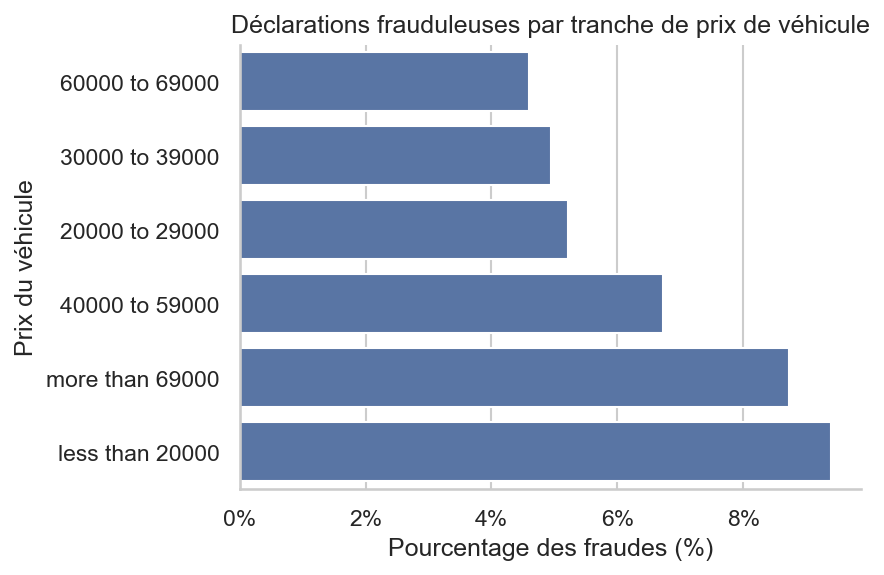

In [157]:
# Distribution des prix de véhicules 
df_counts_vp = df_1["VehiclePrice"].value_counts().sort_index()
df_counts_fraud_vp = df_fraud["VehiclePrice"].value_counts().sort_index()

# Pourcentages de fraud
df_percentages_fraud_vp = pd.DataFrame(round((df_counts_fraud_vp / df_counts_vp) * 100, 2)).fillna(0).reset_index()
df_percentages_fraud_vp.columns = ["VehiclePrice", "Fraud %"]
df_percentages_fraud_vp = df_percentages_fraud_vp.sort_values(by=["Fraud %"])

# Barplot
plt.figure(figsize=(6, 4), dpi=150)
ax = sns.barplot(data=df_percentages_fraud_vp, x="Fraud %", y="VehiclePrice")

ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Pourcentage des fraudes (%)")
ax.set_ylabel("Prix du véhicule")
ax.set_title("Déclarations frauduleuses par tranche de prix de véhicule")

sns.despine()
plt.tight_layout()
plt.show()

On détecte de nombreux cas de fraude que ce soit dans les véhicules les moins chers et dans les véhicules les plus coûteux.

### Fraude et âge du véhicule

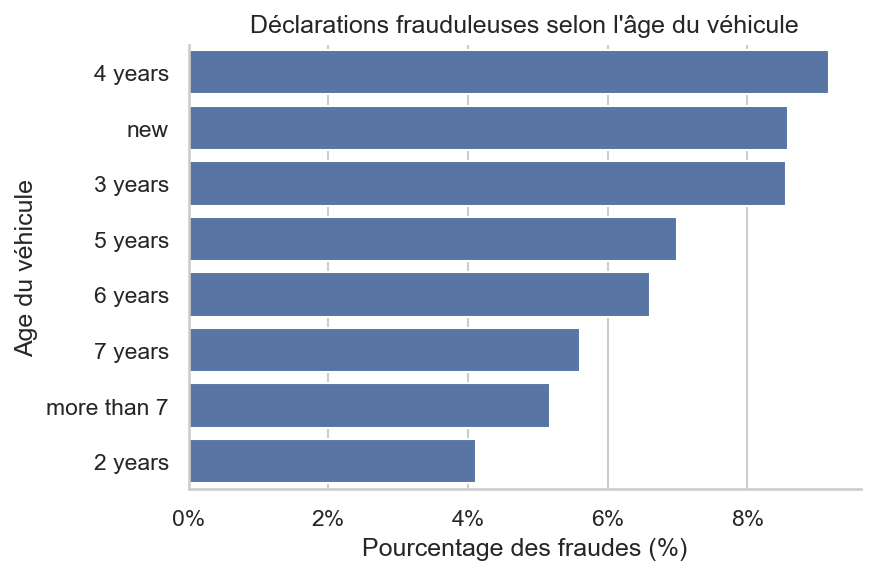

In [15]:
# Distribution des âges de véhicules
df_count_av = df_1["AgeOfVehicle"].value_counts().sort_index()
df_count_fraud_av = df_fraud["AgeOfVehicle"].value_counts().sort_index()

# Pourcentage de fraude
df_percentage_fraud_av = pd.DataFrame(round((df_count_fraud_av / df_count_av) * 100, 2)).fillna(0).reset_index()
df_percentage_fraud_av.columns = ["AgeOfVehicle", "Fraud %"]
df_percentage_fraud_av = df_percentage_fraud_av.sort_values(by=["Fraud %"], ascending=False)

# Barplot
plt.figure(figsize=(6, 4), dpi=150)
ax = sns.barplot(data=df_percentage_fraud_av, x="Fraud %", y="AgeOfVehicle")

ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Pourcentage des fraudes (%)")
ax.set_ylabel("Age du véhicule")
ax.set_title("Déclarations frauduleuses selon l'âge du véhicule")

sns.despine()
plt.tight_layout()
plt.show()

Ici, on ne peut pas dire que la fraude est fonction de l'âge du véhicule, mais on pourrait regrouper cette variable en différentes catégories de niveau de fraude:
- Level 1 : 2 ans et plus de 7 ans
- Level 2 : 5 à 7 ans
- Level 3 : Nouveau et 4 ans

### Fraude en fonction de la base de police et du type de police 

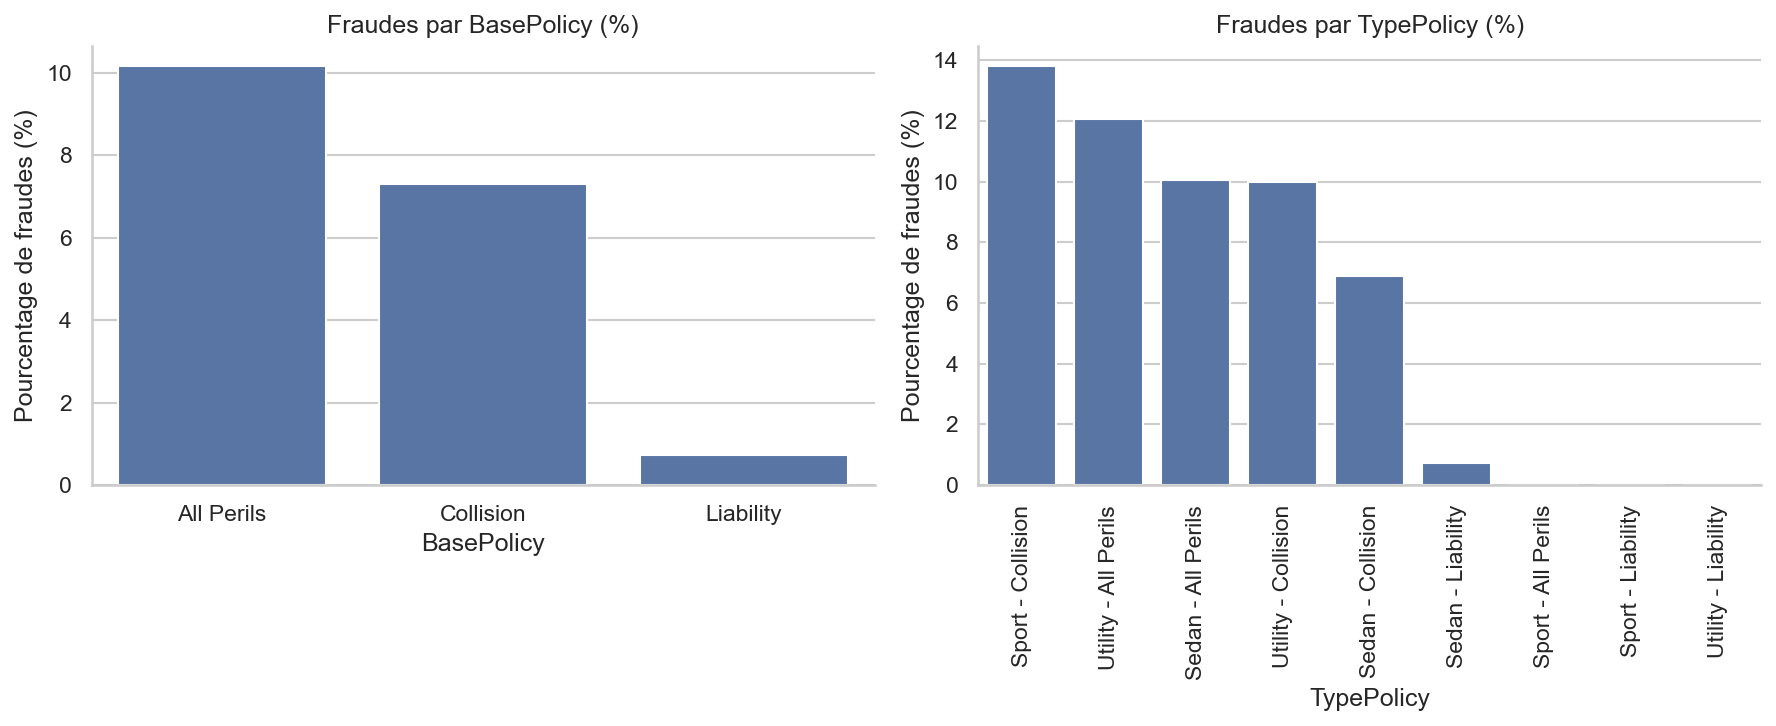

In [158]:
# Distribution de BasePolicy
df_count_bp = df_1["BasePolicy"].value_counts().sort_index()
df_count_fraud_bp = df_fraud["BasePolicy"].value_counts().sort_index()

# Pourcentage de fraude
df_percentage_fraud_bp = pd.DataFrame(round((df_count_fraud_bp / df_count_bp) * 100, 2)).fillna(0).reset_index()
df_percentage_fraud_bp.columns = ["BasePolicy", "Fraud %"]
df_percentage_fraud_bp = df_percentage_fraud_bp.sort_values(by=["Fraud %"], ascending=False)

# Distribution des TypePolicy
df_count_tp = df_1["PolicyType"].value_counts().sort_index()
df_count_fraud_tp = df_fraud["PolicyType"].value_counts().sort_index()

# Pourcentage de fraude
df_percentage_fraud_tp = pd.DataFrame(round((df_count_fraud_tp / df_count_tp) * 100, 2)).fillna(0).reset_index()
df_percentage_fraud_tp.columns = ["PolicyType", "Fraud %"]
df_percentage_fraud_tp = df_percentage_fraud_tp.sort_values(by=["Fraud %"], ascending=False)


# --- Barplots côte à côte ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# BasePolicy
sns.barplot(data=df_percentage_fraud_bp, y="Fraud %", x="BasePolicy", ax=axes[0])
axes[0].set_title("Fraudes par BasePolicy (%)")
axes[0].set_ylabel("Pourcentage de fraudes (%)")
axes[0].set_xlabel("BasePolicy")

# TypePolicy
sns.barplot(data=df_percentage_fraud_tp, y="Fraud %", x="PolicyType", ax=axes[1])
axes[1].set_title("Fraudes par TypePolicy (%)")
axes[1].set_ylabel("Pourcentage de fraudes (%)")
axes[1].set_xlabel("TypePolicy")
axes[1].tick_params(axis="x", labelrotation=90)

sns.despine()
plt.tight_layout()
plt.show()

D’abord, les polices offrant une protection étendue, comme All Perils et Collision, affichent des taux de fraude nettement plus élevés que les polices de responsabilité seule. Ce résultat s’explique par les incitations financières associées : plus la couverture est large, plus le potentiel de remboursement est important, ce qui accroît l’attrait de la fraude. Ensuite, en croisant cette lecture avec le type de véhicule assuré, on observe que les véhicules sportifs et utilitaires sont davantage associés aux fraudes, particulièrement lorsqu’ils sont couverts par des garanties Collision ou All Perils. Ces résultats suggèrent que la fraude est fortement liée à la valeur perçue des indemnisations possibles et aux caractéristiques des véhicules.

### Fraude en fonction du mois de réclamation et du mois de paiement

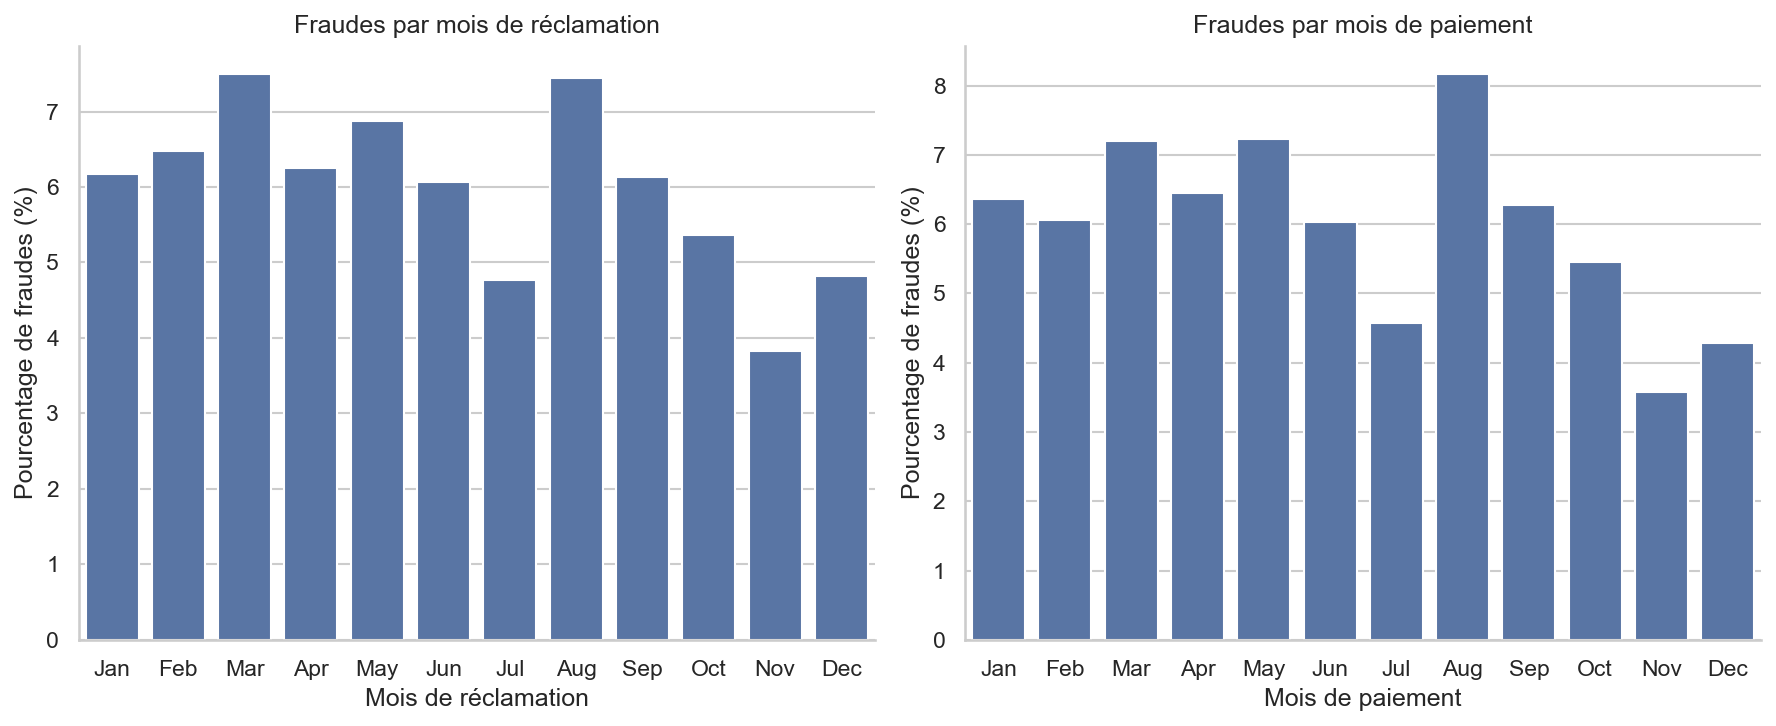

In [159]:
# Distribution de Month
df_count_m = df_1["Month"].value_counts().sort_index()
df_count_fraud_m = df_fraud["Month"].value_counts().sort_index()

# Pourcentage de fraude
df_percentage_fraud_m = pd.DataFrame(round((df_count_fraud_m / df_count_m) * 100, 2)).fillna(0).reset_index()
df_percentage_fraud_m.columns = ["Month", "Fraud %"]

# Distribution des MonthClaimed
df_count_mc = df_1["MonthClaimed"].value_counts().sort_index()
df_count_fraud_mc = df_fraud["MonthClaimed"].value_counts().sort_index()

# Pourcentage de fraude
df_percentage_fraud_mc = pd.DataFrame(round((df_count_fraud_mc / df_count_mc) * 100, 2)).fillna(0).reset_index()
df_percentage_fraud_mc.columns = ["MonthClaimed", "Fraud %"]

# Orde de mois 
month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
# --- Barplots côte à côte ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# BasePolicy
sns.barplot(data=df_percentage_fraud_m, y="Fraud %", x="Month", ax=axes[0], order=month)
axes[0].set_title("Fraudes par mois de réclamation")
axes[0].set_ylabel("Pourcentage de fraudes (%)")
axes[0].set_xlabel("Mois de réclamation")

# TypePolicy
sns.barplot(data=df_percentage_fraud_mc, y="Fraud %", x="MonthClaimed", ax=axes[1], order=month)
axes[1].set_title("Fraudes par mois de paiement")
axes[1].set_ylabel("Pourcentage de fraudes (%)")
axes[1].set_xlabel("Mois de paiement")

sns.despine()
plt.tight_layout()
plt.show()

La variable Month influence légèrement la répartition des fraudes, mais les variations ne sont pas suffisamment marquées ni régulières pour en faire un indicateur déterminant. Le mois de réclamation ou de paiement n’apparaît pas comme une variable significative pour la détection de fraude à lui seul, mais il peut contribuer comme variable secondaire dans un modèle multivarié.

### Fraude et zone d'accident 

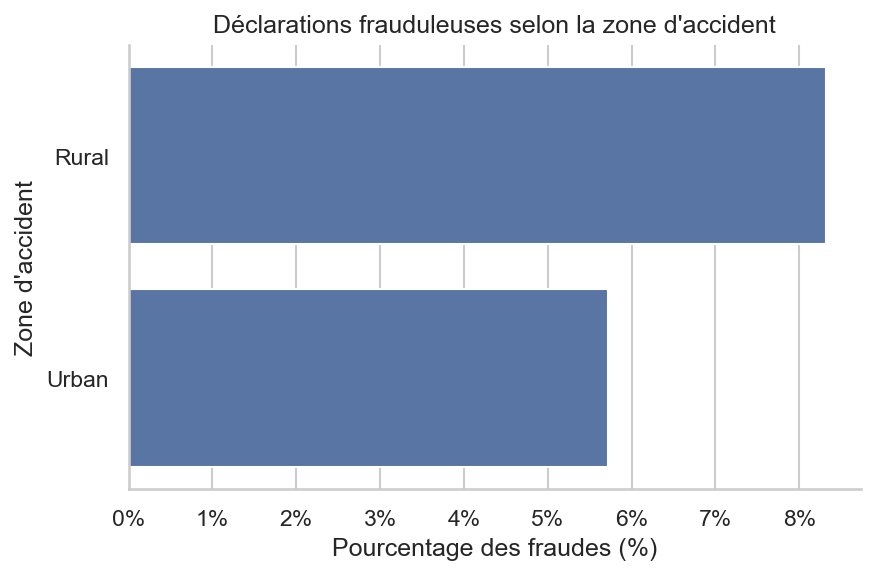

In [160]:
# Distribution des âges de véhicules
df_count_aa = df_1["AccidentArea"].value_counts().sort_index()
df_count_fraud_aa = df_fraud["AccidentArea"].value_counts().sort_index()

# Pourcentage de fraude
df_percentage_fraud_aa = pd.DataFrame(round((df_count_fraud_aa / df_count_aa) * 100, 2)).fillna(0).reset_index()
df_percentage_fraud_aa.columns = ["AccidentArea", "Fraud %"]
df_percentage_fraud_aa = df_percentage_fraud_aa.sort_values(by=["Fraud %"], ascending=False)

# Barplot
plt.figure(figsize=(6, 4), dpi=150)
ax = sns.barplot(data=df_percentage_fraud_aa, x="Fraud %", y="AccidentArea")

ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Pourcentage des fraudes (%)")
ax.set_ylabel("Zone d'accident")
ax.set_title("Déclarations frauduleuses selon la zone d'accident")

sns.despine()
plt.tight_layout()
plt.show()

Les sinistres déclarés en milieu rural semblent plus susceptibles d’être frauduleux que ceux en milieu urbain. Cela peut s’expliquer par une surveillance moindre, un nombre réduit de témoins ou un contrôle plus difficile des circonstances de l’accident. La variable **AccidentArea** apparaît comme potentiellement significative pour la détection de fraude, car l’écart observé est non négligeable et reflète une tendance claire.

### Fraude et responsabilité de l'accident 

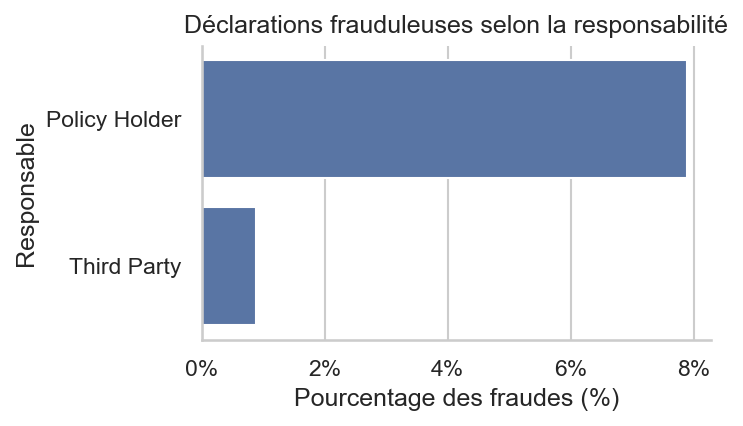

In [161]:
# Distribution des âges de véhicules
df_count_f = df_1["Fault"].value_counts().sort_index()
df_count_fraud_f = df_fraud["Fault"].value_counts().sort_index()

# Pourcentage de fraude
df_percentage_fraud_f = pd.DataFrame(round((df_count_fraud_f / df_count_f) * 100, 2)).fillna(0).reset_index()
df_percentage_fraud_f.columns = ["Fault", "Fraud %"]
df_percentage_fraud_f = df_percentage_fraud_f.sort_values(by=["Fraud %"], ascending=False)

# Barplot
plt.figure(figsize=(5, 3), dpi=150)
ax = sns.barplot(data=df_percentage_fraud_f, x="Fraud %", y="Fault")

ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Pourcentage des fraudes (%)")
ax.set_ylabel("Responsable")
ax.set_title("Déclarations frauduleuses selon la responsabilité")

sns.despine()
plt.tight_layout()
plt.show()

Les résultats indiquent que la responsabilité joue un rôle majeur dans la détection de la fraude : près de 8 % des déclarations frauduleuses proviennent directement des assurés eux-mêmes, contre à peine 1 % lorsqu’un tiers est responsable. Cet écart important suggère que les assurés ont davantage d’incitations financières à manipuler leur déclaration lorsqu'ils sont responsables, ce qui fait de la variable **Fault** un indicateur significatif et pertinent à intégrer dans un modèle de détection de fraude.

### Fraude et présence de témoins 

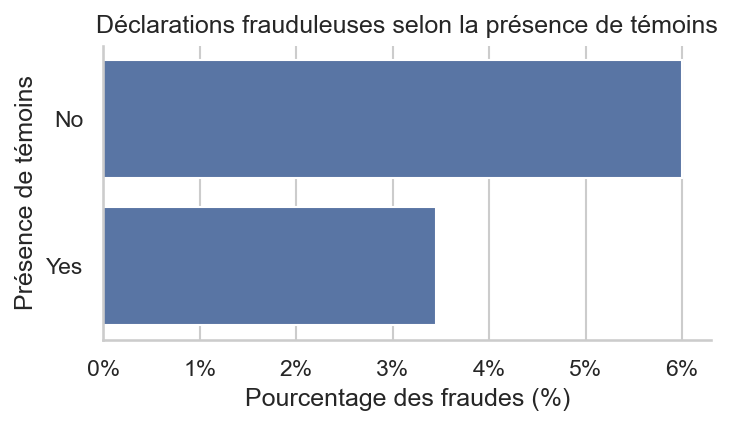

In [162]:
# Distribution des âges de véhicules
df_count_wp = df_1["WitnessPresent"].value_counts().sort_index()
df_count_fraud_wp = df_fraud["WitnessPresent"].value_counts().sort_index()

# Pourcentage de fraude
df_percentage_fraud_wp = pd.DataFrame(round((df_count_fraud_wp / df_count_wp) * 100, 2)).fillna(0).reset_index()
df_percentage_fraud_wp.columns = ["WitnessPresent", "Fraud %"]
df_percentage_fraud_wp = df_percentage_fraud_wp.sort_values(by=["Fraud %"], ascending=False)

# Barplot
plt.figure(figsize=(5, 3), dpi=150)
ax = sns.barplot(data=df_percentage_fraud_wp, x="Fraud %", y="WitnessPresent")

ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Pourcentage des fraudes (%)")
ax.set_ylabel("Présence de témoins")
ax.set_title("Déclarations frauduleuses selon la présence de témoins")

sns.despine()
plt.tight_layout()
plt.show()

On a environ 3.5% des cas frauduleux pour les cas avec témoins contre 6% de fraudes lorsqu'il n'y a pas de témoins. La présence de témoins n'empêche pas l'assuré de frauder mais on note une différence significative entre les deux proportions ce qui indiquent les titulaires de police ont plus tendance à frauder lorsqu'il n'y a pas de témoins.

### Fraude et niveau de conduite 

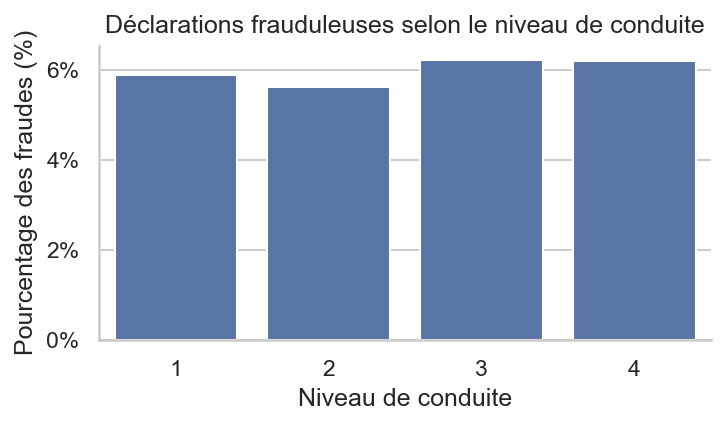

In [163]:
# Distribution des âges de véhicules
df_count_dr = df_1["DriverRating"].value_counts().sort_index()
df_count_fraud_dr = df_fraud["DriverRating"].value_counts().sort_index()

# Pourcentage de fraude
df_percentage_fraud_dr = pd.DataFrame(round((df_count_fraud_dr / df_count_dr) * 100, 2)).fillna(0).reset_index()
df_percentage_fraud_dr.columns = ["DriverRating", "Fraud %"]
df_percentage_fraud_dr = df_percentage_fraud_dr.sort_values(by=["Fraud %"], ascending=False)

# Barplot
plt.figure(figsize=(5, 3), dpi=150)
ax = sns.barplot(data=df_percentage_fraud_dr, y="Fraud %", x="DriverRating")

ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax.set_ylabel("Pourcentage des fraudes (%)")
ax.set_xlabel("Niveau de conduite")
ax.set_title("Déclarations frauduleuses selon le niveau de conduite")

sns.despine()
plt.tight_layout()
plt.show()

On observe pas vraiement de différence significative dans la distribution des cas de fraude selon le niveau de conduite. Cette variable ne sera vraisemblablement utile pour détecter les cas de fraude.

### Fraude et les autres variables explicatives

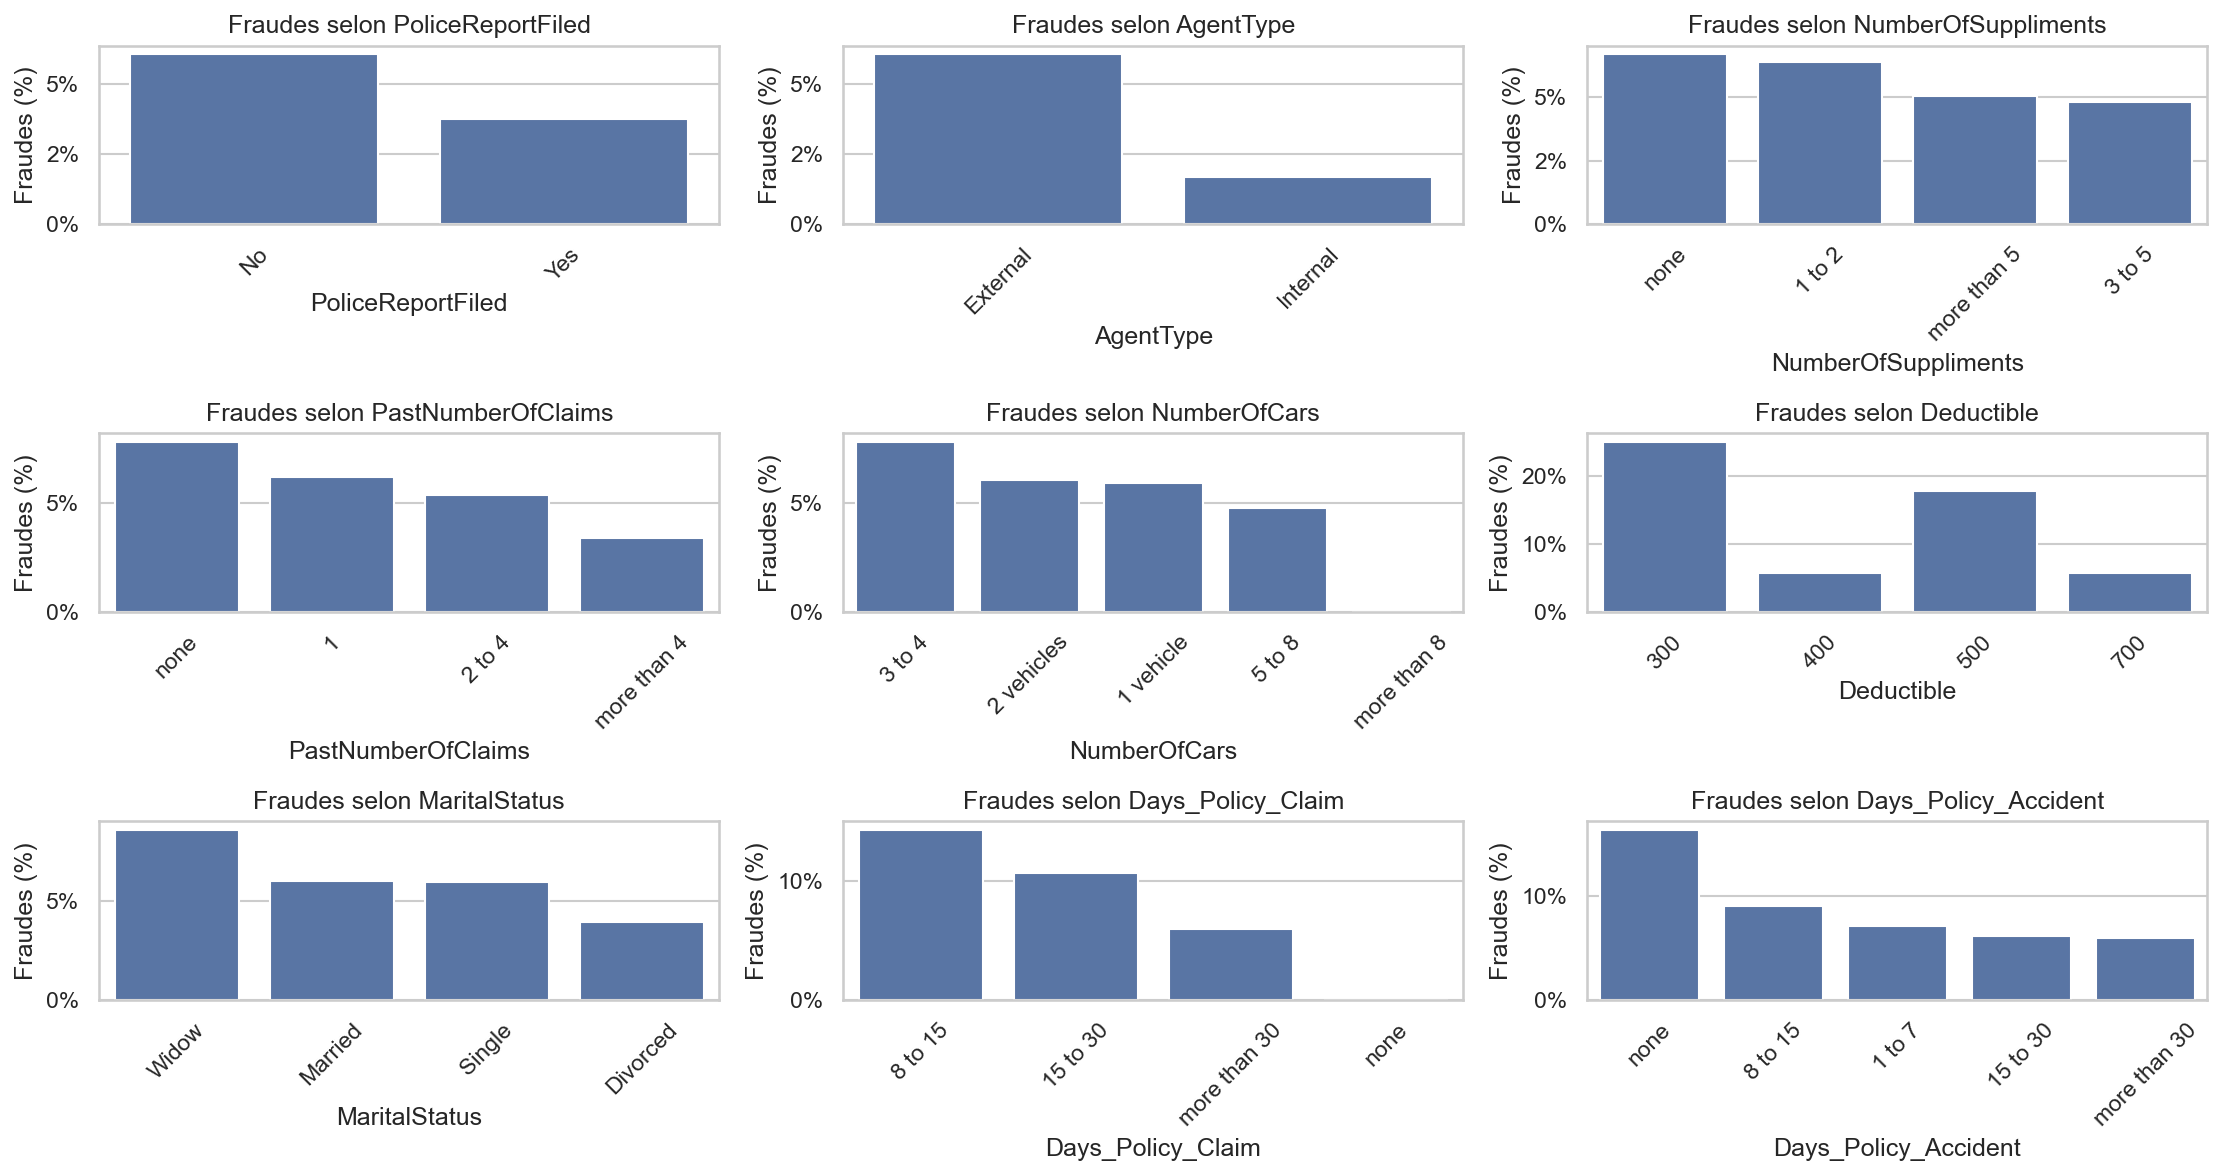

In [164]:
# Variables à analyser
var = ["PoliceReportFiled", "AgentType", "NumberOfSuppliments", 
       "PastNumberOfClaims", "NumberOfCars", "Deductible", "MaritalStatus",
      "Days_Policy_Claim", "Days_Policy_Accident"]

# Traitement 
df_viz = df_1.copy()
df_viz["Deductible"] = df_1["Deductible"].astype(str)

# Création de la grille 
fig, axes = plt.subplots(3, 3, figsize=(15, 8), dpi=150)
axes = axes.flatten()

# Boucle sur chaque variable
for i, v in enumerate(var):
    # Comptage global et frauduleux
    df_count = df_1[v].value_counts().sort_index()
    df_count_fraud = df_fraud[v].value_counts().sort_index()

    # Pourcentage de fraude
    df_percentage_fraud = pd.DataFrame(
        round((df_count_fraud / df_count) * 100, 2)
    ).fillna(0).reset_index()

    df_percentage_fraud.columns = [v, "Fraud %"]
    df_percentage_fraud = df_percentage_fraud.sort_values(by="Fraud %", ascending=False)

    # Barplot dans la grille
    sns.barplot(data=df_percentage_fraud, x=v, y="Fraud %", ax=axes[i])
    axes[i].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    axes[i].set_ylabel("Fraudes (%)")
    axes[i].set_xlabel(v)
    axes[i].set_title(f"Fraudes selon {v}")
    axes[i].tick_params(axis="x", rotation=45)

# Supprimer éventuelle case vide si nb variables < nb cases
for j in range(len(var), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- **PoliceReportFiled**. Les déclarations sans dépôt de rapport de police présentent le taux de fraude le plus élevé (≈6 %), signe qu’un moindre niveau de traçabilité et de vérification facilite les tentatives de fraude. À l’inverse, la présence d’un rapport officiel réduit nettement ce taux, probablement grâce au contrôle documentaire et aux risques accrus de détection.
- **AgentType**. Les contrats issus d’agents externes affichent un taux de fraude sensiblement supérieur (≈6 %) à ceux gérés par des agents internes (≈1,5 %). 
- **NumberOfSuppliments**. On observe une fraude un peu plus élevée lorsqu’aucun supplément n’est déclaré, puis des niveaux proches (5–6 %) pour les autres classes. Le signal existe mais reste modéré : cette variable seule discrimine peu, surtout sans tenir compte des montants et de la nature des suppléments.
- **PastNumberOfClaims**. Paradoxalement, les assurés sans antécédents présentent le taux de fraude le plus élevé (≈8 %), alors que le risque décroît avec le nombre de réclamations passées. Cela peut traduire un biais de sélection (nouveaux assurés moins connus) ou des comportements opportunistes ponctuels.
- **NumberOfCars**. Le risque augmente pour les portefeuilles comportant 3 à 4 véhicules (≈8 %), puis baisse au-delà. La multiplicité de véhicules accroît les occasions de sinistre (et donc de fraude), mais les très grands parcs semblent plus surveillés et professionnalisés.
- **Deductible**. Les franchines des différents contrats sont 300, 400, 500, 700. On note une différence significative dans la distribution des cas de fraudes mais cette différence n'évolue pas en fonction du montant.
- **MaritalStatus**. On note plus de cas de fraudes chez les veufs/veuves. Les mariés et les célibataires présentent des taux pratiquement similaires. On pourrait regrouper ces 2 modalités.
- **Days_Policy_Claim**. Plus une réclamation est faite tôt après l'entrée en vigueur de la police, plus cette reclamation est susceptible d'être une fraude.
- **Days_Policy_Accident**. On note la même tendance qu'avzc **Days_Policy_Claim** mais les cas inconnus représentent le groupe avec le plus de cas de fraude.

Les variables les plus discriminantes pour la détection de fraude sont PoliceReportFiled et AgentType (écarts nets et cohérents). PastNumberOfClaims et NumberOfCars apportent un signal utile mais contextuel, tandis que NumberOfSuppliments est faiblement informatif seul. 

## Prétraitement des données 

In [165]:
df_clean = df.copy()
df_clean.shape

(15420, 33)

### Encodage des variables binaires
AccidentArea, Sex, Fault, PoliceReporteFiled, WitnessPresent, AgentType

In [166]:
# Sélection des variables binaires
binary_columns = [col for col in df_clean.columns if df_clean[col].nunique() == 2 and col != "FraudFound_P"]
print("Le nombre de variables binaires : ", len(binary_columns))
print("Variables binaires : ", binary_columns)

Le nombre de variables binaires :  6
Variables binaires :  ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']


In [167]:
le = LabelEncoder()

for col in binary_columns:
    df_clean[col] = le.fit_transform(df_clean[col])
    print("Labl mapping: ", dict(zip(le.classes_, le.transform(le.classes_))))

Labl mapping:  {'Rural': np.int64(0), 'Urban': np.int64(1)}
Labl mapping:  {'Female': np.int64(0), 'Male': np.int64(1)}
Labl mapping:  {'Policy Holder': np.int64(0), 'Third Party': np.int64(1)}
Labl mapping:  {'No': np.int64(0), 'Yes': np.int64(1)}
Labl mapping:  {'No': np.int64(0), 'Yes': np.int64(1)}
Labl mapping:  {'External': np.int64(0), 'Internal': np.int64(1)}


### Encodage des variables catégorielles ordinales et nominales 
Dans l'analyse exploratoire, on a décidé de regrouper les modalités des variables **VehiclePrice**, **AgeOfVehicle** pour représenter différents niveaux de fraude. Pour la variable **BasePolicy**, on peut la transformer en variable ordinale pour refléter les niveaux de protections offertes. 
- **VehiclePrice** est transformée en variable binaire au lieu d'une variable ordinale. Cela est dû que l'on notait des hauts taux de fraudes pour certaines modalités qui ne ne suivaient pas une évolution selon l'ordre.
- **AgeOfVehicle** est transformée en variable catégorielle pour la même raison que **VehiclePrice** en 3 catégories.
- **BasePolicy** garde quant à elle sa caractérisque de variable catégorielle ordinale.

In [168]:
# Liste des variables et modalités 
for col in ["VehiclePrice", "AgeOfVehicle", "BasePolicy"]:
    print(f"Les modalités dans {col} : {df_clean[col].unique()}")

Les modalités dans VehiclePrice : ['more than 69000' '20000 to 29000' '30000 to 39000' 'less than 20000'
 '40000 to 59000' '60000 to 69000']
Les modalités dans AgeOfVehicle : ['3 years' '6 years' '7 years' 'more than 7' '5 years' 'new' '4 years'
 '2 years']
Les modalités dans BasePolicy : ['Liability' 'Collision' 'All Perils']


In [169]:
# Les différents niveaux de modalités 
vehicleprice_label = {"more than 69000": 1, "20000 to 29000": 0, "30000 to 39000": 0,
                     "less than 20000": 1, "40000 to 59000": 1, "60000 to 69000": 0}

ageofvehicle_label = {"new": 2, "2 years": 0, "3 years": 2, "4 years":2, "5 years": 1,
                     "6 years": 1, "7 years": 0, "more than 7": 0}

basepolicy_label = {"Liability": 0, "Collision": 1, "All Perils": 2}

In [171]:
# Transformation 
df_clean['VehiclePrice'] = df_clean["VehiclePrice"].map(vehicleprice_label)
df_clean['AgeOfVehicle'] = df_clean['AgeOfVehicle'].map(ageofvehicle_label)
df_clean['BasePolicy'] = df_clean['BasePolicy'].map(basepolicy_label)

In [190]:
df_clean2 = df_clean.copy()
df_clean2.shape

(15420, 33)

### Gestion de valeurs aberrante 

Comme on l'avait mentionné lors de l'analyse descriptive des variables, il n'est pas normal d'avoir des âges de 0. Il semble également avoir des outliers au delà de 75 ans. On va donc utiliser une méthode d'imputation par arbres aléatoires pour régler ces cas.

In [191]:
num_to_str = ["RepNumber", "Deductible", "Year"]

for col in num_to_str:
    df_clean2[col] = df_clean2[col].astype(str)

In [192]:
var_cat = ["Make", "MaritalStatus", "PolicyType", "VehicleCategory", "RepNumber",
          "Deductible", "Days_Policy_Accident", "Days_Policy_Claim", "PastNumberOfClaims", "AgeOfPolicyHolder", "NumberOfSuppliments",
          "AddressChange_Claim", "NumberOfCars", "Year"]
print("Le nombre de variables à encoder : ", len(var_cat))

Le nombre de variables à encoder :  14


In [209]:
df_clean3 = pd.get_dummies(df_clean2, columns=var_cat)
df_clean3.shape

(15420, 113)

In [177]:
df_clean3.columns.to_list()

['Month',
 'WeekOfMonth',
 'DayOfWeek',
 'AccidentArea',
 'DayOfWeekClaimed',
 'MonthClaimed',
 'WeekOfMonthClaimed',
 'Sex',
 'Age',
 'Fault',
 'VehiclePrice',
 'FraudFound_P',
 'PolicyNumber',
 'DriverRating',
 'AgeOfVehicle',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'BasePolicy',
 'Make_Accura',
 'Make_BMW',
 'Make_Chevrolet',
 'Make_Dodge',
 'Make_Ferrari',
 'Make_Ford',
 'Make_Honda',
 'Make_Jaguar',
 'Make_Lexus',
 'Make_Mazda',
 'Make_Mecedes',
 'Make_Mercury',
 'Make_Nisson',
 'Make_Pontiac',
 'Make_Porche',
 'Make_Saab',
 'Make_Saturn',
 'Make_Toyota',
 'Make_VW',
 'MaritalStatus_Divorced',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'MaritalStatus_Widow',
 'PolicyType_Sedan - All Perils',
 'PolicyType_Sedan - Collision',
 'PolicyType_Sedan - Liability',
 'PolicyType_Sport - All Perils',
 'PolicyType_Sport - Collision',
 'PolicyType_Sport - Liability',
 'PolicyType_Utility - All Perils',
 'PolicyType_Utility - Collision',
 'PolicyType_Utility - Liability

Text(0.5, 1.0, "Boxplot de l'âge")

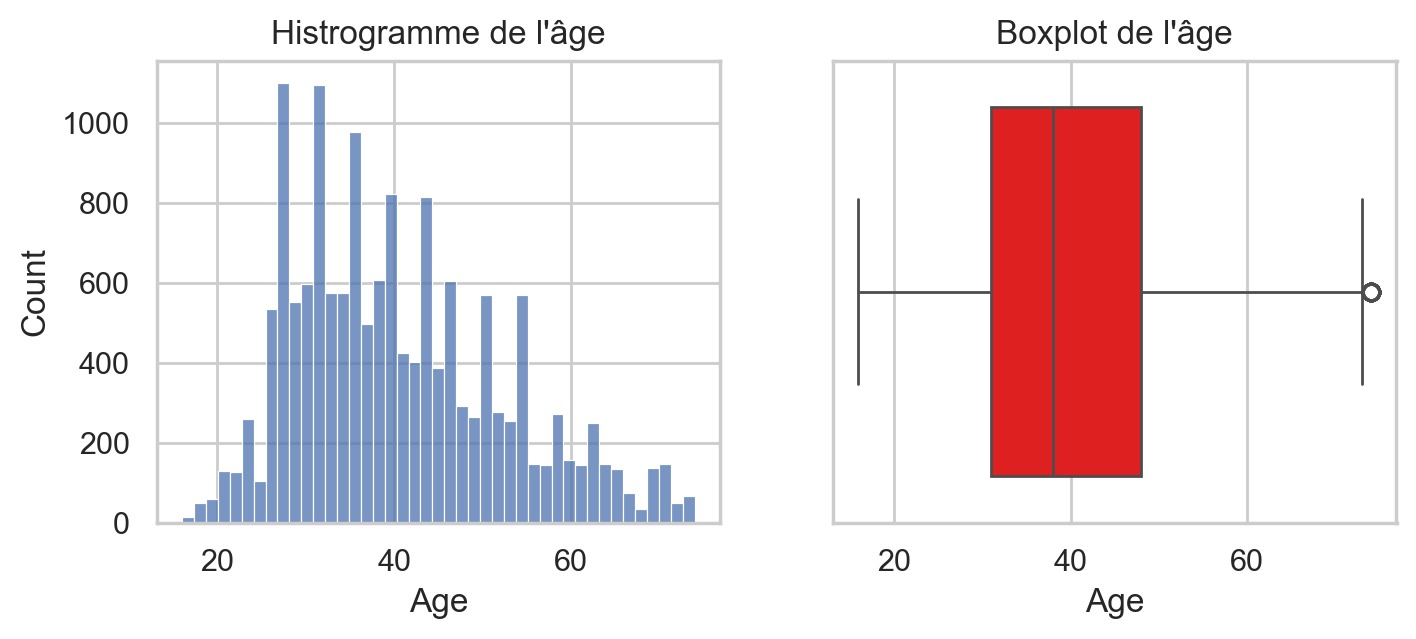

In [211]:
# Création de la grille 
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
axes = axes.flatten()

# Histogramme
sns.histplot(data=df_clean3, x="Age", ax=axes[0])
axes[0].set_title("Histrogramme de l'âge")

# Boxplot
sns.boxplot(data=df_clean3, x="Age", ax=axes[1], color="red")
axes[1].set_title("Boxplot de l'âge")

In [212]:
def lightgbm_imputation(dataframe, var, num_boost_round=200):
    """
    Impute les valeurs manquantes de `var` via LightGBM (régression).
    - Convertit les colonnes object en category et aligne les catégories train/test.
    - Retourne le DataFrame avec `var` imputée si nécessaire, sinon inchangé.
    """
    df = dataframe.copy()

    # Sépare apprentissage (valeurs connues) et test (valeurs manquantes)
    train_mask = df[var].notna()
    test_mask  = ~train_mask

    if test_mask.sum() == 0:
        # Rien à imputer
        return df

    X_train = df.loc[train_mask].drop(columns=[var])
    y_train = df.loc[train_mask, var]
    X_test  = df.loc[test_mask].drop(columns=[var])

    # Sécurité : s'assurer que X_test est bien un DataFrame non vide
    if not isinstance(X_test, pd.DataFrame) or X_test.shape[0] == 0:
        return df  # Rien à prédire finalement

    # Harmoniser les colonnes (ordre identique)
    X_test = X_test[X_train.columns]

    # Convertir les colonnes object en category et ALIGNER les catégories
    obj_cols = [c for c in X_train.columns if X_train[c].dtype == 'object' or str(X_train[c].dtype).startswith('category')]
    for c in obj_cols:
        both = pd.concat([X_train[c], X_test[c]], axis=0)
        cats = pd.Categorical(both).categories
        X_train[c] = pd.Categorical(X_train[c], categories=cats)
        X_test[c]  = pd.Categorical(X_test[c],  categories=cats)

    # LightGBM accepte les NaN dans les features. On indique les colonnes catégorielles.
    train_dataset = lgb.Dataset(
        X_train,
        label=y_train,
        categorical_feature=obj_cols if len(obj_cols) > 0 else 'auto',
        free_raw_data=True
    )

    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "verbosity": -1
    }

    model = lgb.train(params, train_dataset, num_boost_round=num_boost_round)

    # Prédiction (X_test est garanti 2D et non vide ici)
    pred = model.predict(X_test)

    # Écrire les imputations AU BON ENDROIT (df, pas df_clean3)
    df.loc[test_mask, var] = pred

    return df


In [213]:
# Changer les 0 et les outliers en valeurs manquantes
df_clean3["Age"] = df_clean3["Age"].apply(lambda x: np.nan if x == 0 or x > 74 else x)

In [214]:
# Application de la méthode d'imputation 
to_delete = ["Month", "DayOfWeek", "DayOfWeekClaimed", "MonthClaimed"]
df_drop = df_clean3.drop(to_delete, axis=1)
df_imputed = lightgbm_imputation(df_drop, "Age")

Text(0.5, 1.0, "Boxplot de l'âge")

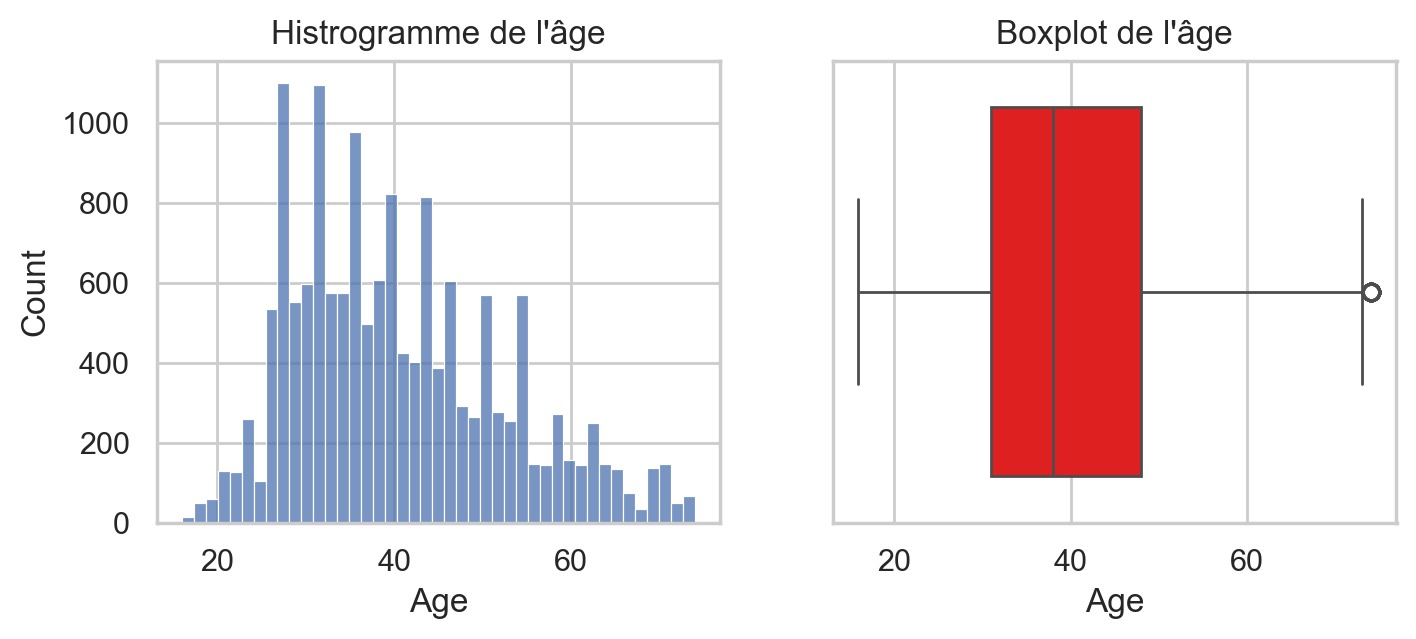

In [198]:
# Création de la grille 
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
axes = axes.flatten()

# Histogramme
sns.histplot(data=df_imputed, x="Age", ax=axes[0])
axes[0].set_title("Histrogramme de l'âge")

# Boxplot
sns.boxplot(data=df_imputed, x="Age", ax=axes[1], color="red")
axes[1].set_title("Boxplot de l'âge")

In [217]:
df_clean2["Age"] = df_imputed["Age"]
df_clean2.shape

(15420, 33)

### Suppression des variables inutiles 

In [219]:
var_drop = ["WeekOfMonth", "DayOfWeek", "DayOfWeekClaimed", "WeekOfMonthClaimed", "PolicyNumber", "MonthClaimed"]
df_clean4 = df_clean2.drop(columns=var_drop, axis=1)
df_clean4.shape

(15420, 27)

In [201]:
df_clean4.columns.to_list()

['Month',
 'Make',
 'AccidentArea',
 'Sex',
 'MaritalStatus',
 'Age',
 'Fault',
 'PolicyType',
 'VehicleCategory',
 'VehiclePrice',
 'FraudFound_P',
 'RepNumber',
 'Deductible',
 'DriverRating',
 'Days_Policy_Accident',
 'Days_Policy_Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'NumberOfSuppliments',
 'AddressChange_Claim',
 'NumberOfCars',
 'Year',
 'BasePolicy']

In [202]:
df_clean4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Month                 15420 non-null  object 
 1   Make                  15420 non-null  object 
 2   AccidentArea          15420 non-null  int64  
 3   Sex                   15420 non-null  int64  
 4   MaritalStatus         15420 non-null  object 
 5   Age                   15420 non-null  float64
 6   Fault                 15420 non-null  int64  
 7   PolicyType            15420 non-null  object 
 8   VehicleCategory       15420 non-null  object 
 9   VehiclePrice          15420 non-null  int64  
 10  FraudFound_P          15420 non-null  int64  
 11  RepNumber             15420 non-null  object 
 12  Deductible            15420 non-null  object 
 13  DriverRating          15420 non-null  int64  
 14  Days_Policy_Accident  15420 non-null  object 
 15  Days_Policy_Claim  

## Transformation des variables catégorielles  
On utilise un encodage disjonctif pour les autres variables catégorielles non binaires

In [232]:
num_to_str = ["RepNumber", "Deductible", "Year"]

for col in num_to_str:
    df_clean4[col] = df_clean4[col].astype(str)

var_cat = ["Make", "MaritalStatus", "PolicyType", "VehicleCategory", "RepNumber",
          "Deductible", "Days_Policy_Accident", "Days_Policy_Claim", "PastNumberOfClaims", "AgeOfPolicyHolder", "NumberOfSuppliments",
          "AddressChange_Claim", "NumberOfCars", "Year", "Month"]

df_clean5 = pd.get_dummies(df_clean4, columns=var_cat)
df_clean5.shape


(15420, 118)

## Suréchantillonnage aléatoire
Comme constaté au début de l'analyse, on a un déséquilibre des effectifs de la variable de fraude. Appliquer un modèle sur de telles données avec comme métrique la précision, nous donnerait une bonne métrique mais qui serait uniquement due à la bonne capacité du modèle à prédire les cas non frauduleux. On utilise donc ici la méthode **SMOTE** qui est une méthode utilisée en machine learning pour gérer les problèmes des déséquilibres dans les données. Elle permet de créer de nouvelles observations similaires au cas de fraudes ce qui permet d'avoir assez de cas frauduleux pour notre modèle.

In [233]:
# Données d'entrainement et de Test 
X = df_clean5.drop(columns="FraudFound_P")
y = df_clean5["FraudFound_P"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)
pd.Series(y_train).value_counts()

FraudFound_P
0    11598
1      738
Name: count, dtype: int64

In [234]:
smote = SMOTE(random_state=2025)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train, )

print("Avant SMOTE: ", X_train.shape, y_train.shape)
print("Après SMOTE: ", X_train_sm.shape, y_train_sm.shape)
print()
print("Après SMOTE, distribution de la variable de fraude: ", pd.Series(y_train_sm).value_counts())

Avant SMOTE:  (12336, 117) (12336,)
Après SMOTE:  (23196, 117) (23196,)

Après SMOTE, distribution de la variable de fraude:  FraudFound_P
0    11598
1    11598
Name: count, dtype: int64


In [236]:
df_smote = pd.concat([X_train_sm, y_train_sm], axis=1)
df_smote.shape

(23196, 118)

## Sélection des variable 
On utilise ici la méthode RFECV (Recursive Feature Elimination Cross Validation) qui est une méthode récursive de sélection de variable qui supprime récursivement les variables les moins importantes. Elle combine l'élimination récursive de variables et la validation croisée pour évaluer la performance à chaque étape.

In [238]:
X_sm = df_smote.drop(columns="FraudFound_P")
y_sm = df_smote["FraudFound_P"]
print(X_sm.shape, y_sm.shape)

(23196, 117) (23196,)


Avant d'appliquer RFECV, on fait une préselection des variables en utilisant **VarianceThreshold** qui est une méthode de sélection de variables qui supprimes les variables ayant une faible variance. Elle permet de réduire le bruit en éliminant les variables à faible variance, qui semblent peu informatives.

In [244]:
select = VarianceThreshold(threshold=0.01)

X_reduit = select.fit_transform(X_sm)
X_reduit.shape

(23196, 85)

In [245]:
select_var_indx = select.get_support(indices=True)
select_nom_var = X_sm.columns[select_var_indx]
X_reduit = pd.DataFrame(X_reduit, columns=select_nom_var)

On utilise ici LightGBM comme classificateur pour RFECV car la majorité de nos variables sont catégorielles. 

In [246]:
lightgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=2025, verbose=-1)

In [248]:
rfecv = RFECV(estimator=lightgbm_model, step=1, cv=StratifiedKFold(5), scoring="roc_auc", n_jobs=1)
rfecv.fit(X_reduit, y_sm)

C:\Users\jonat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-p

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(random_state=2025, verbose=-1), n_jobs=1,
      scoring='roc_auc')

In [249]:
nb_var_optimal = rfecv.n_features_
print("Le nombre de variables optimales sont:", nb_var_optimal)

Le nombre de variables optimales sont: 57


In [250]:
X_select = rfecv.transform(X_reduit)

In [260]:
select_var_indx = np.where(rfecv.support_)[0]
select_nom_var = X_reduit.columns[select_var_indx]
X_rfecv = pd.DataFrame(X_select, columns=select_nom_var)
X_rfecv.columns

Index(['AccidentArea', 'Age', 'Fault', 'VehiclePrice', 'DriverRating',
       'BasePolicy', 'Make_Accura', 'Make_Chevrolet', 'Make_Ford',
       'Make_Honda', 'Make_Mazda', 'Make_Pontiac', 'Make_Saab', 'Make_Toyota',
       'MaritalStatus_Married', 'MaritalStatus_Single',
       'PolicyType_Sedan - All Perils', 'PolicyType_Sport - Collision',
       'VehicleCategory_Sedan', 'VehicleCategory_Utility', 'RepNumber_1',
       'RepNumber_10', 'RepNumber_11', 'RepNumber_14', 'RepNumber_15',
       'RepNumber_2', 'RepNumber_3', 'RepNumber_5', 'RepNumber_6',
       'RepNumber_7', 'RepNumber_9', 'Deductible_500', 'PastNumberOfClaims_1',
       'PastNumberOfClaims_2 to 4', 'PastNumberOfClaims_more than 4',
       'PastNumberOfClaims_none', 'NumberOfSuppliments_1 to 2',
       'NumberOfSuppliments_3 to 5', 'NumberOfSuppliments_more than 5',
       'NumberOfSuppliments_none', 'AddressChange_Claim_2 to 3 years',
       'AddressChange_Claim_no change', 'Year_1994', 'Year_1995', 'Year_1996',
       '

## Modélisation 

Les algorithmes utilisés sont :
- **Logistics Regression**: Un modèle linéaire pour la classification de variables binaires qui prédit les probabilités
- **Support Vector Machine (SVM)**: classe les données en trouvant un hyperplan qui maximise la marge entre les classes
- **KNN**: prédit la classe basée sur la majorité des classes parmi les K voisins les plus proches.
- **RandomForest**: Un ensemble d'arbres de décision qui améliore la prédiction en faisant une moyenne des arbres.
- **LightGBM**: utilise des algorithmes baséssur des arbres, optimisés pour la vitesse et l'efficacité
- **CatBoost**:

In [257]:
rfecv_col = X_rfcv.columns.tolist()
X_rfecv_test = X_test[rfecv_col]

In [261]:
def objectif_essai(trial):
    """
    Fonction objectif utilisée par Optuna pour optimiser automatiquement le choix du modèle
    de classification et ses hyperparamètres. Elle entraîne différents modèles sur l’ensemble
    d’entraînement, ajuste le seuil de décision optimal en fonction du score F1, puis retourne
    le score AUC obtenu sur l’ensemble de test.

    Paramètres
    ----------
    trial : optuna.trial.Trial
        Objet représentant un essai (trial) dans l’optimisation. Permet de proposer différentes
        valeurs pour les hyperparamètres et de stocker des informations personnalisées.

    Retour
    ------
    float
        Score AUC (Area Under the ROC Curve) obtenu sur l’ensemble de test avec le meilleur seuil.
    """

    # Choix du classifieur à tester parmi une liste prédéfinie
    nom_modele = trial.suggest_categorical(
        "modele",
        ["LogisticRegression", "SVM", "KNeighbors", "RandomForest", "LightGBM", "CatBoost"]
    )

    # === 1. Modèle : Régression Logistique ===
    if nom_modele == "LogisticRegression":
        C = trial.suggest_float("lr_C", 0.1, 10.0)
        solveur = trial.suggest_categorical("lr_solver", ["liblinear"])
        modele = LogisticRegression(C=C, solver=solveur)

    # === 2. Modèle : SVM ===
    elif nom_modele == "SVM":
        C = trial.suggest_float("svm_C", 0.1, 10.0)
        noyau = trial.suggest_categorical("svm_kernel", ["linear", "rbf"])
        modele = SVC(C=C, kernel=noyau, probability=True)

    # === 3. Modèle : K-Plus Proches Voisins (KNN) ===
    elif nom_modele == "KNeighbors":
        n_voisins = trial.suggest_int("kn_n_neighbors", 3, 7)
        modele = KNeighborsClassifier(n_neighbors=n_voisins)

    # === 4. Modèle : Forêt Aléatoire ===
    elif nom_modele == "RandomForest":
        n_arbres = trial.suggest_int("rf_n_estimators", 100, 200)
        profondeur_max = trial.suggest_categorical("rf_max_depth", [10, 20, None])
        modele = RandomForestClassifier(n_estimators=n_arbres, max_depth=profondeur_max)

    # === 5. Modèle : LightGBM ===
    elif nom_modele == "LightGBM":
        nb_feuilles = trial.suggest_int("lgb_num_leaves", 31, 50)
        taux_apprentissage = trial.suggest_float("lgb_learning_rate", 0.01, 0.2)
        n_iter = trial.suggest_int("lgb_n_estimators", 100, 200)
        modele = lgb.LGBMClassifier(
            num_leaves=nb_feuilles,
            learning_rate=taux_apprentissage,
            n_estimators=n_iter,
            verbose=-1
        )

    # === 6. Modèle : CatBoost ===
    elif nom_modele == "CatBoost":
        iterations = trial.suggest_int("cat_iterations", 100, 200)
        taux_apprentissage = trial.suggest_float("cat_learning_rate", 0.01, 0.2)
        profondeur = trial.suggest_int("cat_depth", 3, 9)
        modele = CatBoostClassifier(
            iterations=iterations,
            learning_rate=taux_apprentissage,
            depth=profondeur,
            verbose=0
        )

    # === Entraînement du modèle ===
    modele.fit(X_rfecv, y_sm)

    # === Probabilités prédites sur l'ensemble test ===
    y_prob = modele.predict_proba(X_rfecv_test)[:, 1]

    # === Recherche du seuil optimal pour maximiser le score F1 ===
    seuils_possibles = np.arange(0.1, 0.9, 0.01)
    meilleur_seuil = 0.5
    meilleur_score_f1 = 0.0

    for seuil in seuils_possibles:
        y_pred = (y_prob >= seuil).astype(int)
        score_f1 = f1_score(y_test, y_pred)
        if score_f1 > meilleur_score_f1:
            meilleur_score_f1 = score_f1
            meilleur_seuil = seuil

    # === Sauvegarde des infos utiles dans l'objet trial ===
    trial.set_user_attr("meilleur_seuil", meilleur_seuil)
    trial.set_user_attr("modele_entraine", modele)

    # === Calcul du score AUC avec le meilleur seuil trouvé ===
    y_pred_final = (y_prob >= meilleur_seuil).astype(int)
    score_auc = roc_auc_score(y_test, y_pred_final)

    return score_auc


In [263]:
# Réduit le niveau de verbosité d'Optuna : seuls les avertissements et erreurs seront affichés
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [266]:
# Création d'une étude Optuna qui cherche à maximiser la métrique (ici le score AUC)
# en utilisant le sampler TPE (Tree-structured Parzen Estimator) pour explorer efficacement l'espace d'hyperparamètres
study = optuna.create_study(direction="maximize", sampler=TPESampler())

# Lancement de l'optimisation sur 100 essais en utilisant la fonction objectif définie plus haut
study.optimize(objectif_essai, n_trials=100)

In [267]:
best_trial = study.best_trial
print("Best trial: ", best_trial.values)
print("Best hyperparameters: ", best_trial.params)

Best trial:  [0.7839786319606947]
Best hyperparameters:  {'modele': 'LightGBM', 'lgb_num_leaves': 34, 'lgb_learning_rate': 0.0775831720806738, 'lgb_n_estimators': 149}


In [273]:
best_algo = [trial.params["modele"] for trial in study.trials]
algo_counts = pd.Series(best_algo).value_counts()
algo_counts

LightGBM              65
LogisticRegression     8
KNeighbors             7
CatBoost               7
RandomForest           7
SVM                    6
Name: count, dtype: int64

In [275]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold):
    """
    Entraîne un modèle sur l'ensemble d'entraînement, applique un seuil de décision personnalisé
    sur les probabilités prédites, puis calcule différentes métriques de performance sur l'ensemble test.

    Paramètres
    ----------
    model : object
        Modèle de classification (doit avoir les méthodes fit et predict_proba).
    X_train : array-like
        Variables explicatives de l'ensemble d'entraînement.
    y_train : array-like
        Cibles de l'ensemble d'entraînement.
    X_test : array-like
        Variables explicatives de l'ensemble de test.
    y_test : array-like
        Cibles de l'ensemble de test.
    threshold : float
        Seuil de décision appliqué aux probabilités prédites pour déterminer les classes (0 ou 1).

    Retour
    ------
    tuple
        (accuracy, precision, recall, f1, roc_auc) — les métriques de performance calculées sur l'ensemble test.
    """

    # 1. Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    # 2. Prédiction des probabilités sur l'ensemble de test (colonne 1 = probabilité de la classe positive)
    y_prob = model.predict_proba(X_test)[:, 1]

    # 3. Conversion en classes (0/1) en appliquant le seuil choisi
    y_pred = (y_prob >= threshold).astype(int)

    # 4. Calcul des différentes métriques de performance
    accuracy = accuracy_score(y_test, y_pred)      # Taux de bonnes classifications
    precision = precision_score(y_test, y_pred)    # Proportion de prédictions positives correctes
    recall = recall_score(y_test, y_pred)          # Taux de vrais positifs détectés
    f1 = f1_score(y_test, y_pred)                  # Moyenne harmonique entre précision et rappel
    roc_auc = roc_auc_score(y_test, y_pred)        # Aire sous la courbe ROC basée sur les prédictions binaires

    # 5. Retourne toutes les métriques sous forme de tuple
    return accuracy, precision, recall, f1, roc_auc

In [280]:
# Sélection des 5 meilleurs essais (trials) en fonction de leur valeur (ici le score AUC)
top_5_trials = study.trials_dataframe().sort_values(by='value', ascending=False).head(5)

# Liste pour stocker les résultats détaillés des 5 meilleurs modèles
results = []

# Boucle sur chacun des meilleurs essais pour réentraîner le modèle correspondant
for i, row in top_5_trials.iterrows():
    # Récupération du nom du modèle testé
    model_name = row['params_modele']  

    # Récupération du meilleur seuil de décision stocké pendant l'optimisation
    threshold = study.trials[row['number']].user_attrs['meilleur_seuil']

    # Récupération des hyperparamètres du modèle gagnant
    model_params = study.trials[row['number']].params

    # === 1. Création du modèle correspondant avec les bons hyperparamètres ===
    if model_name == 'LogisticRegression':
        params = {
            'C': model_params['lr_C'],
            'solver': model_params['lr_solver']
        }
        final_model = LogisticRegression(**params)

    elif model_name == 'SVM':
        params = {
            'C': model_params['svm_C'],
            'kernel': model_params['svm_kernel']
        }
        final_model = SVC(**params, probability=True)

    elif model_name == 'KNeighbors':
        params = {
            'n_neighbors': model_params['kn_n_neighbors']
        }
        final_model = KNeighborsClassifier(**params)

    elif model_name == 'RandomForest':
        params = {
            'n_estimators': model_params['rf_n_estimators'],
            'max_depth': model_params['rf_max_depth']
        }
        final_model = RandomForestClassifier(**params)

    elif model_name == 'LightGBM':
        params = {
            'num_leaves': model_params['lgb_num_leaves'],
            'learning_rate': model_params['lgb_learning_rate'],
            'n_estimators': model_params['lgb_n_estimators']
        }
        final_model = lgb.LGBMClassifier(**params, verbose=-1)

    elif model_name == 'CatBoost':
        params = {
            'iterations': model_params['cat_iterations'],
            'learning_rate': model_params['cat_learning_rate'],
            'depth': model_params['cat_depth']
        }
        final_model = CatBoostClassifier(**params, verbose=0)

    # === 2. Évaluation du modèle sur les données de test avec le seuil choisi ===
    accuracy, precision, recall, f1, roc_auc = evaluate_model(
        final_model, X_rfecv, y_sm, X_rfecv_test, y_test, threshold
    )

    # === 3. Sauvegarde des résultats dans une liste ===
    results.append({
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'best_params': params,
        'best_threshold': threshold
    })

# Conversion de la liste de dictionnaires en DataFrame pour visualisation claire
results_df = pd.DataFrame(results)

In [281]:
results_df

model  accuracy  precision    recall  f1_score   roc_auc  \
0  LightGBM  0.803178   0.200284  0.762162  0.317210  0.783979   
1  LightGBM  0.797341   0.193593  0.751351  0.307863  0.775814   
2  LightGBM  0.827497   0.216039  0.713514  0.331658  0.774142   
3  LightGBM  0.818093   0.204403  0.702703  0.316687  0.764080   
4  LightGBM  0.809339   0.196992  0.708108  0.308235  0.761953   

                                         best_params  best_threshold  
0  {'num_leaves': 34, 'learning_rate': 0.07758317...             0.1  
1  {'num_leaves': 33, 'learning_rate': 0.07694818...             0.1  
2  {'num_leaves': 37, 'learning_rate': 0.12906952...             0.1  
3  {'num_leaves': 31, 'learning_rate': 0.14203969...             0.1  
4  {'num_leaves': 31, 'learning_rate': 0.13670109...             0.1

In [283]:
# --- 1) Sélection du meilleur modèle selon la métrrique choisie dans results_df ---
results_df = results_df.sort_values(by="roc_auc", ascending=False).reset_index(drop=True)

# Extraction des infos du meilleur modèle
best_model_info = results_df.iloc[0]
best_model = best_model_info['model']
best_model_params = best_model_info['best_params']
best_threshold = best_model_info['best_threshold']

# --- 2) Reconstruction du modèle avec ses meilleurs hyperparamètres ---
final_model = None
if best_model == 'LogisticRegression':
    final_model = LogisticRegression(**best_model_params)
elif best_model == 'SVM':
    final_model = SVC(**best_model_params, probability=True)
elif best_model == 'KNeighbors':
    final_model = KNeighborsClassifier(**best_model_params)
elif best_model == 'RandomForest':
    final_model = RandomForestClassifier(**best_model_params)
elif best_model == 'LightGBM':
    final_model = lgb.LGBMClassifier(**best_model_params, verbose=-1)
elif best_model == 'CatBoost':
    final_model = CatBoostClassifier(**best_model_params, verbose=0)
else:
    raise ValueError(f"Modèle non supporté: {best_model}")

# --- 3) Entraînement sur l'ensemble d'entraînement ---
final_model.fit(X_rfecv, y_sm)  

# --- 4) Importance des variables par permutation ---
result = permutation_importance(
    estimator=final_model,
    X=X_rfecv_test,
    y=y_test,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'  
)

# Moyenne des importances par permutation
feature_importance = result.importances_mean
features = X_rfecv.columns  # s’assurer que l’ordre des colonnes correspond bien à X_rfecv_test

# --- 5) DataFrame des importances triées ---
importance_df = (
    pd.DataFrame({'feature': features, 'importance': feature_importance})
      .sort_values(by='importance', ascending=False)
      .reset_index(drop=True)
)

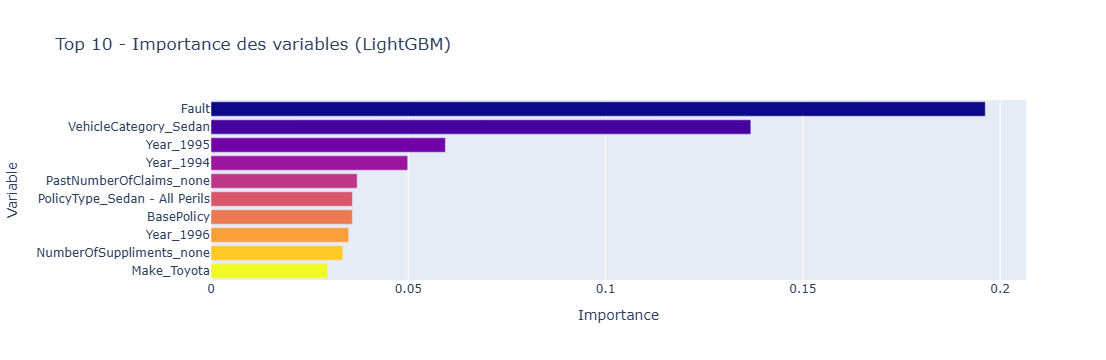

In [284]:
# --- 1) Sélection des 10 variables les plus importantes ---
top_features_df = importance_df.head(10).copy()

# --- 2) Attribution de couleurs selon le rang d'importance ---
colors = px.colors.sequential.Plasma_r
num_colors = len(colors)

# Classement des importances (rang croissant)
ranked_importance = top_features_df['importance'].rank(method='max', ascending=True)

# Conversion des rangs en indices de couleur dans la palette
color_indices = (ranked_importance / ranked_importance.max() * (num_colors - 1)).astype(int)

# Création d'une colonne 'color' pour chaque variable selon son rang
top_features_df.loc[:, 'color'] = color_indices.apply(lambda x: colors[x])

# --- 3) Création du graphique en barres horizontales ---
fig = go.Figure(go.Bar(
    x=top_features_df['importance'],  # Axe X : valeurs d'importance
    y=top_features_df['feature'],     # Axe Y : noms des variables
    orientation='h',                  # Barres horizontales
    marker=dict(color=top_features_df['color']),  # Couleur personnalisée par rang
))

# --- 4) Personnalisation du layout ---
fig.update_layout(
    title=f'Top 10 - Importance des variables ({best_model})',
    xaxis_title='Importance',
    yaxis_title='Variable',
    yaxis=dict(autorange="reversed")  # Inverse l’ordre pour avoir la plus importante en haut
)

# --- 5) Affichage du graphique ---
fig.show()


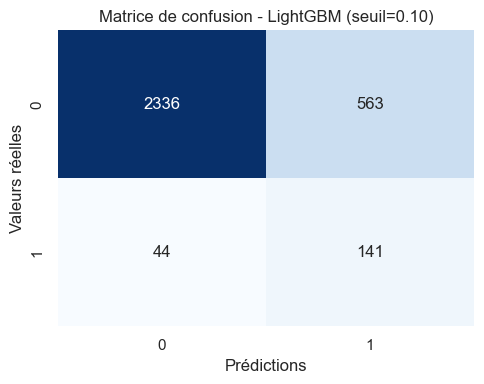

In [286]:
from sklearn.metrics import confusion_matrix

# --- 1) Entraînement du meilleur modèle sur l'ensemble d'entraînement ---
final_model.fit(X_rfecv, y_sm)  

# --- 2) Prédictions de probabilité sur l'ensemble de test ---
y_prob_final = final_model.predict_proba(X_rfecv_test)[:, 1]

# --- 3) Application du meilleur seuil pour obtenir des prédictions binaires ---
y_pred_final = (y_prob_final >= best_threshold).astype(int)

# --- 4) Calcul de la matrice de confusion ---
cm = confusion_matrix(y_test, y_pred_final)

# --- 5) Affichage ---
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title(f"Matrice de confusion - {best_model} (seuil={best_threshold:.2f})")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.tight_layout()
plt.show()


La matrice de confusion du modèle LightGBM avec un seuil de décision fixé à 0,10 met en évidence un bon équilibre entre la détection des fraudes et le contrôle des erreurs, tout en privilégiant clairement le rappel. Le modèle identifie correctement 2336 cas négatifs sur le total, ce qui traduit une bonne capacité à reconnaître les observations non frauduleuses. Cependant, 563 cas négatifs ont été classés à tort comme positifs, ce qui indique une augmentation des faux positifs due au seuil bas. Du côté des fraudes réelles, le modèle parvient à en détecter 141 correctement, tout en en manquant 44, soit relativement peu de faux négatifs. Globalement, cette configuration reflète une approche axée sur la maximisation de la détection : on accepte davantage de fausses alertes afin de réduire au minimum le risque de passer à côté d’un cas positif. Cette stratégie peut être pertinente dans notre contexte de détection de fraude en assurance, où les conséquences d’une fraude non détectée sont souvent plus importantes que celles d’une vérification supplémentaire sur un faux positif.